# **Introduction**

Le cancer du sein est le cancer le plus fréquent chez les femmes dans le monde entier. Selon l'**Organisation Mondiale de la Santé** (OMS), environ 2,3 millions de nouveaux cas de cancer du sein ont été diagnostiqués en 2020.

Dans ce notebook, nous allons travailler avec le jeu de données **Breast Cancer Wisconsin (Diagnostic)**, qui contient des données sur les caractéristiques des cellules d'un échantillon de tissu mammaire de patientes atteintes de cancer du sein. L'objectif de ce notebook est d'analyser ces données, de visualiser les relations entre les caractéristiques et le diagnostic (bénin ou malin), et de construire des modèles de machine learning pour prédire le diagnostic à partir des caractéristiques des cellules.

Nous allons commencer par explorer les données en utilisant des visualisations, puis nous allons construire plusieurs modèles de machine learning pour prédire le diagnostic. Nous évaluerons ensuite la performance de ces modèles et sélectionnerons celui qui donne les meilleures prédictions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

%matplotlib inline

In [2]:
cancer = pd.read_csv('/kaggle/input/cancer-data/Cancer_Data.csv')

In [3]:
cancer.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [4]:
cancer.set_index('id', inplace=True)
cancer.drop('Unnamed: 32', axis=1, inplace=True)

In [5]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [6]:
cancer.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

In [7]:
num_var = list(cancer.select_dtypes('number').columns)

In [8]:
(cancer.isnull().sum() / cancer.shape[0]) * 100

diagnosis                  0.0
radius_mean                0.0
texture_mean               0.0
perimeter_mean             0.0
area_mean                  0.0
smoothness_mean            0.0
compactness_mean           0.0
concavity_mean             0.0
concave points_mean        0.0
symmetry_mean              0.0
fractal_dimension_mean     0.0
radius_se                  0.0
texture_se                 0.0
perimeter_se               0.0
area_se                    0.0
smoothness_se              0.0
compactness_se             0.0
concavity_se               0.0
concave points_se          0.0
symmetry_se                0.0
fractal_dimension_se       0.0
radius_worst               0.0
texture_worst              0.0
perimeter_worst            0.0
area_worst                 0.0
smoothness_worst           0.0
compactness_worst          0.0
concavity_worst            0.0
concave points_worst       0.0
symmetry_worst             0.0
fractal_dimension_worst    0.0
dtype: float64

# **Exploratory Data Analysis (EDA)**

In [9]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

<AxesSubplot:>

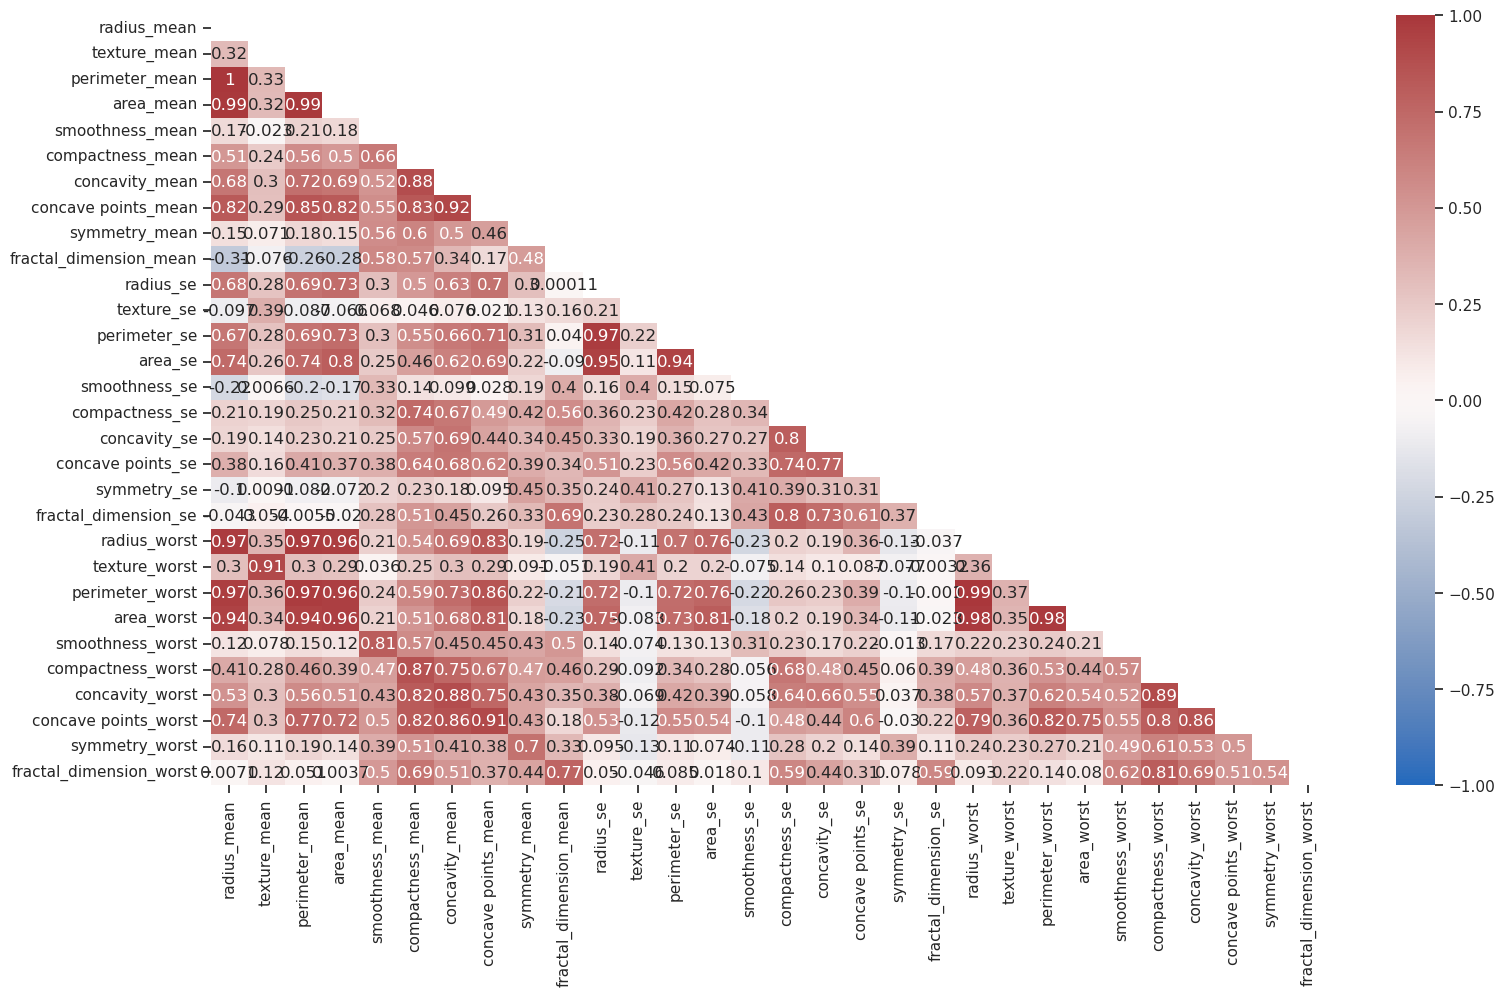

In [10]:
plt.figure(figsize=(18,10))
sns.heatmap(cancer.corr(), vmin=-1, vmax=1, annot=True,
            mask=np.triu(cancer.corr()), cmap=sns.color_palette("vlag", as_cmap=True))

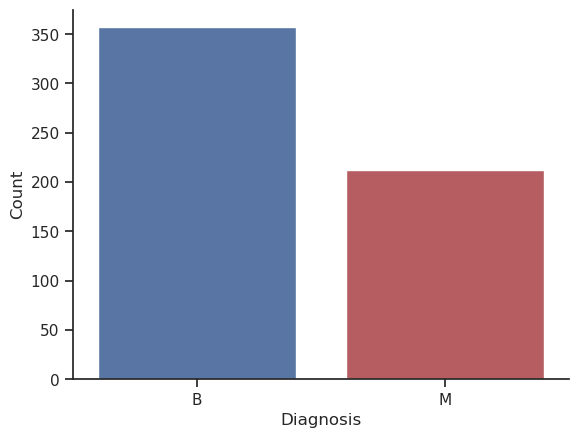

In [11]:
diagnosis_counts = cancer.groupby(by=['diagnosis']).size().reset_index(name='count')
sns.barplot(x="diagnosis", y="count", data=diagnosis_counts, palette=["#4C72B0","#C44E52"])
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

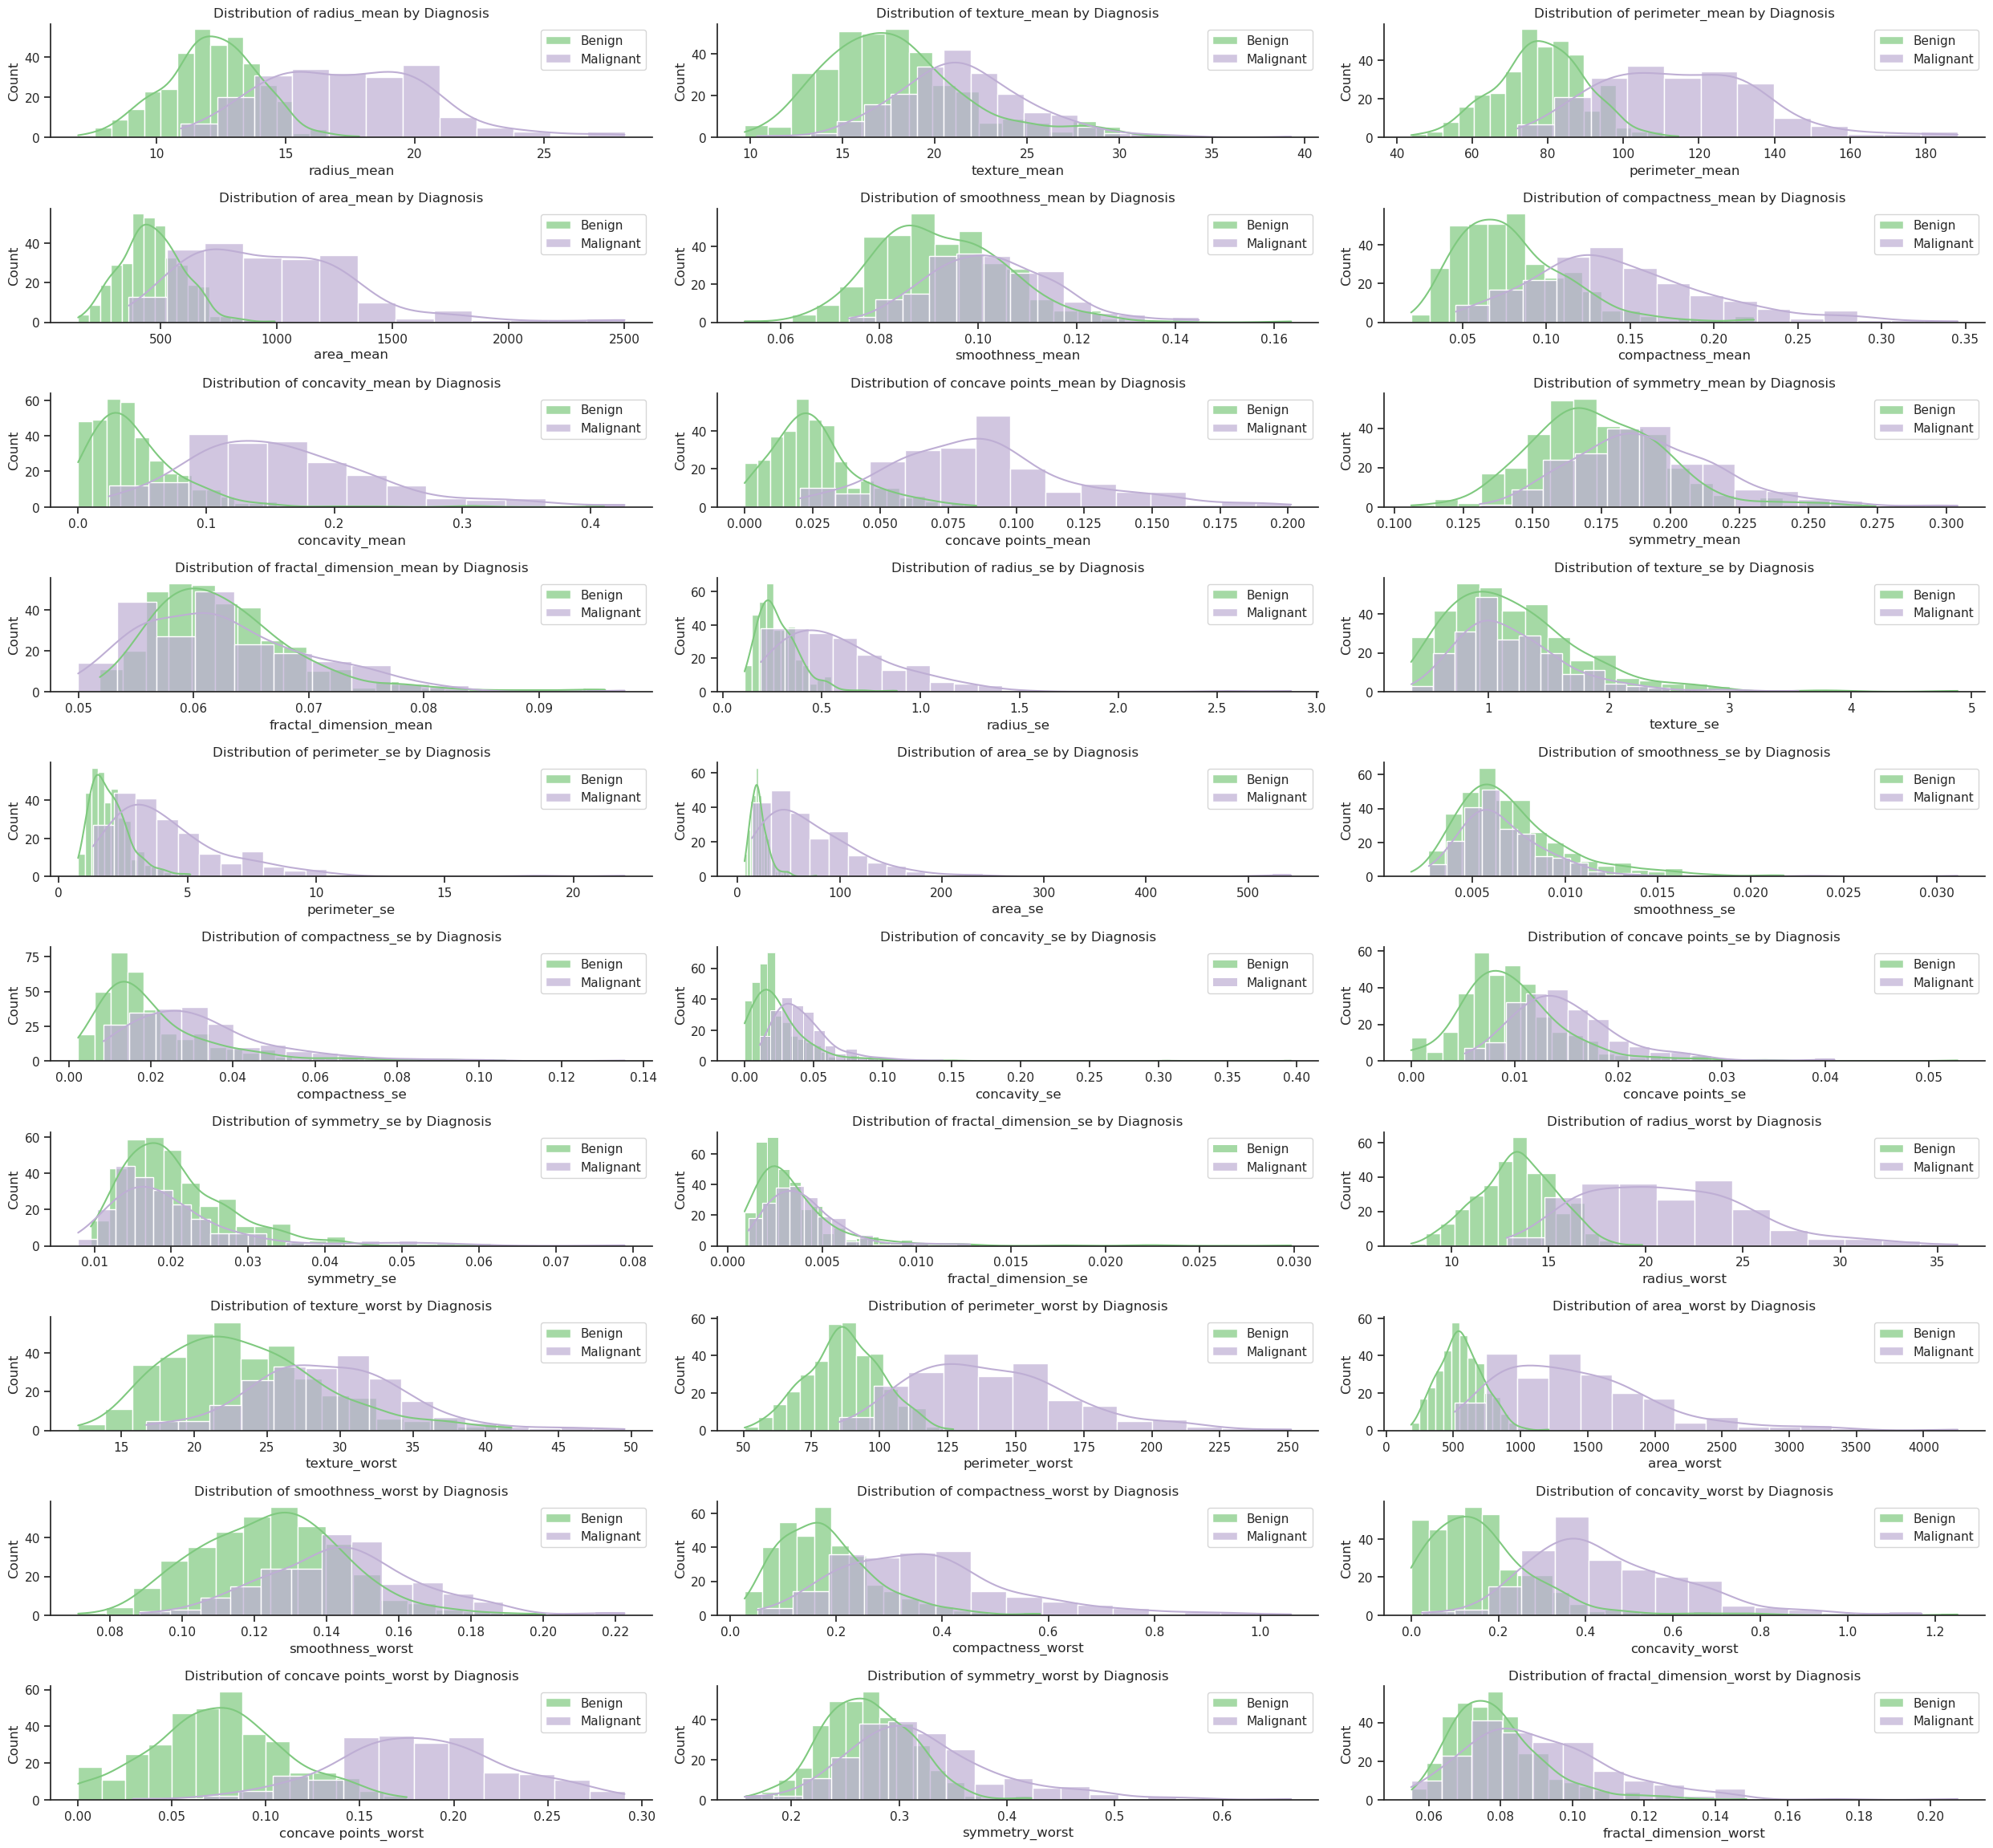

In [12]:
# Crée un sous-ensemble pour les tumeurs bénignes et malveillantes
benign = cancer[cancer['diagnosis'] == 'B']
malignant = cancer[cancer['diagnosis'] == 'M']

# Définis le nombre de lignes et de colonnes de sous-graphiques
nrows = len(num_var) // 3 + 1
ncols = 3

# Boucle sur les variables numériques pour créer des histogrammes séparés pour chaque classe
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
for i, colname in enumerate(num_var):
    row = i // ncols
    col = i % ncols
    sns.histplot(data=benign, x=colname, kde=True, color='#7fc97f', label='Benign', alpha=0.7, ax=axes[row][col])
    sns.histplot(data=malignant, x=colname, kde=True, color='#beaed4', label='Malignant', alpha=0.7, ax=axes[row][col])
    axes[row][col].set_xlabel(colname)
    axes[row][col].set_ylabel('Count')
    axes[row][col].set_title('Distribution of ' + colname + ' by Diagnosis')
    axes[row][col].legend()

# Supprime les sous-graphiques inutilisés
for i in range(len(num_var), nrows*ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.show()

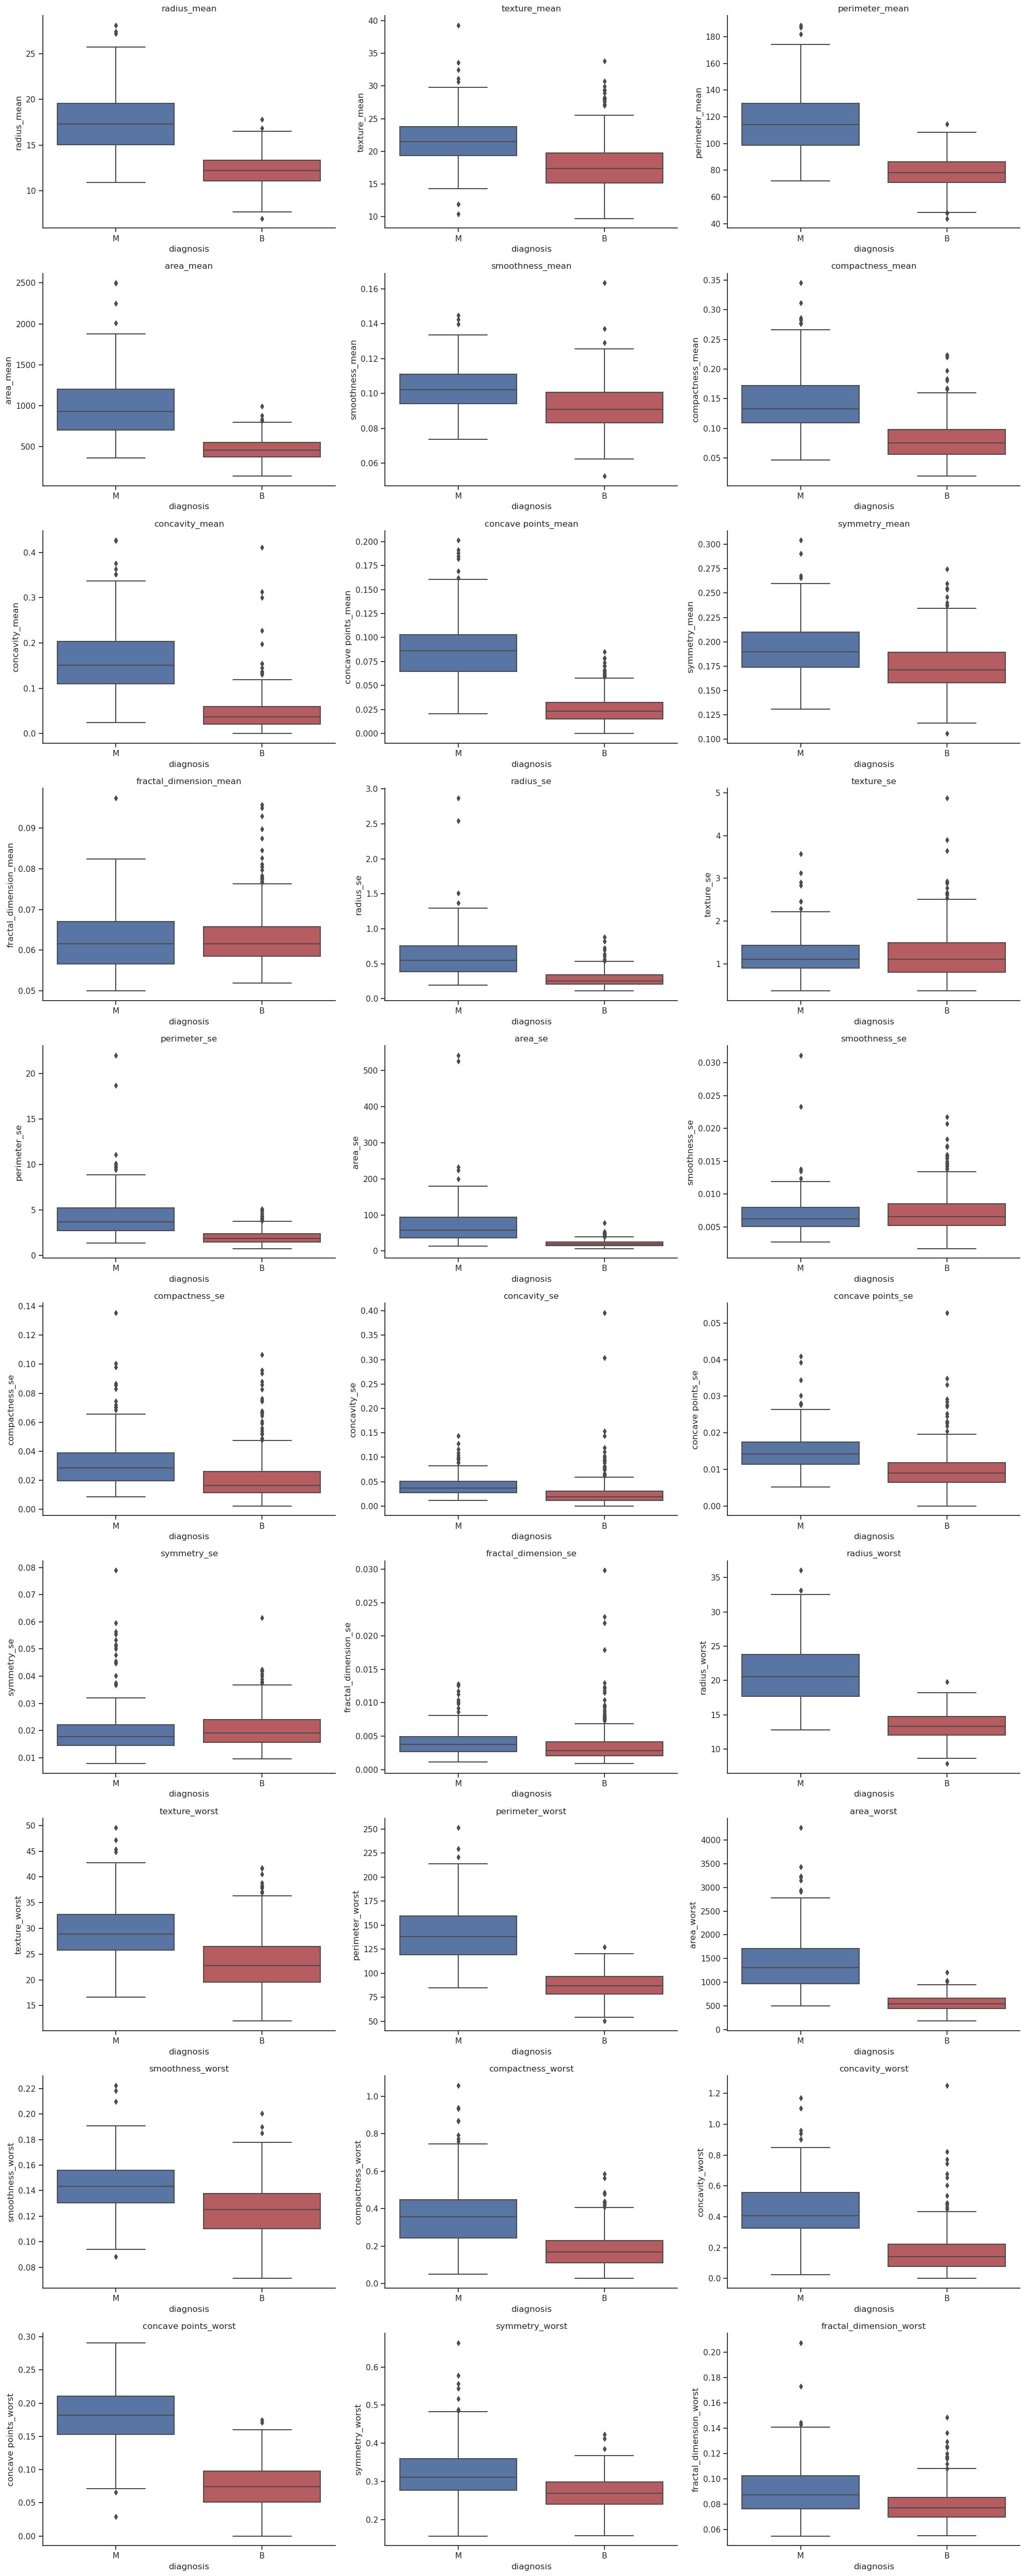

In [13]:
cols = cancer.loc[:,'radius_mean':'fractal_dimension_worst'].columns
n_rows = (len(cols) + 2) // 3
palette = ['#4C72B0', '#C44E52']
fig, axs = plt.subplots(n_rows, 3, figsize=(20, 5*n_rows))
axs = axs.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x='diagnosis', y=col, data=cancer, ax=axs[i], palette=palette)
    axs[i].set_title(col)

# Supprime les axes inutiles
for ax in axs[len(cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

## **Principal Components Analysis**

In [14]:
X_pca, y_pca = cancer.select_dtypes('number'), cancer['diagnosis']
X_pca.shape, y_pca.shape

((569, 30), (569,))

In [15]:
pca = PCA(n_components=3) # instanciation de l'objet pca
scaler_pca = StandardScaler() # instanciation de l'objet scaler_pca 
X_scaled_pca = scaler_pca.fit_transform(X_pca) # normalisation centrée-réduite
X_transformed_pca = pca.fit_transform(X_scaled_pca) # réalisation de l'ACP sur les données X_scaled_pca
X_transformed_df = pd.DataFrame(X_transformed_pca, columns=['PC1', 'PC2', 'PC3'])
X_transformed_df['diagnosis'] = list(cancer['diagnosis'])

In [16]:
total_var = pca.explained_variance_ratio_.sum() * 100

Text(0, 0.5, 'Explained Variance Ratio (%)')

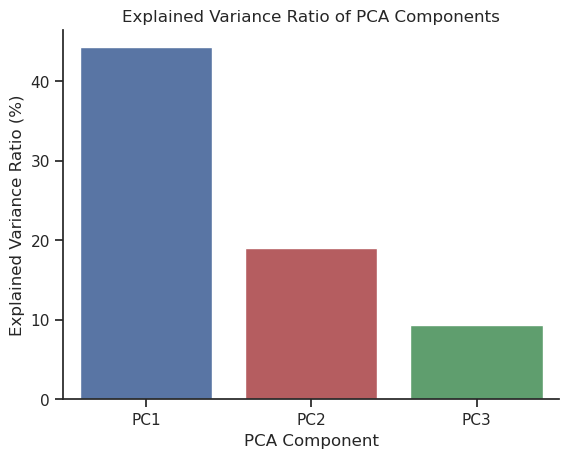

In [17]:
# Création de la série de données avec les pourcentages de variance expliquée
variance_ratios = pd.Series(dict(zip(['PC1', 'PC2', 'PC3'], 100.0*pca.explained_variance_ratio_)))

# Configuration du graphique en barres
ax = sns.barplot(x=variance_ratios.index, y=variance_ratios.values, palette=["#4C72B0","#C44E52","#55A868"])
ax.set_title('Explained Variance Ratio of PCA Components')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio (%)')

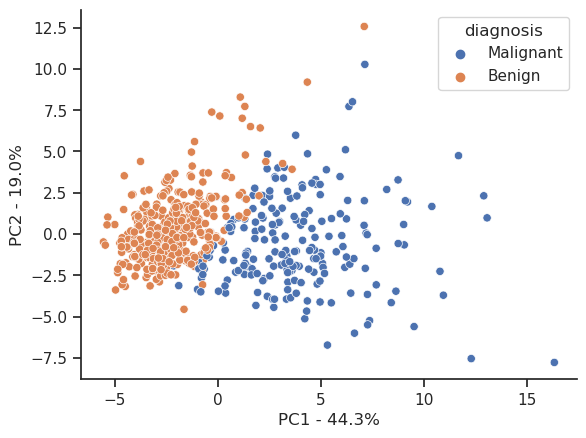

In [18]:
X_transformed_df = X_transformed_df.replace({'B': 'Benign', 'M':'Malignant'})
sns.scatterplot(data=X_transformed_df, x='PC1', y='PC2', hue='diagnosis')
plt.xlabel('PC1 - ' + '{:.1f}%'.format(variance_ratios['PC1']))
plt.ylabel('PC2 - ' + '{:.1f}%'.format(variance_ratios['PC2']))
plt.show()

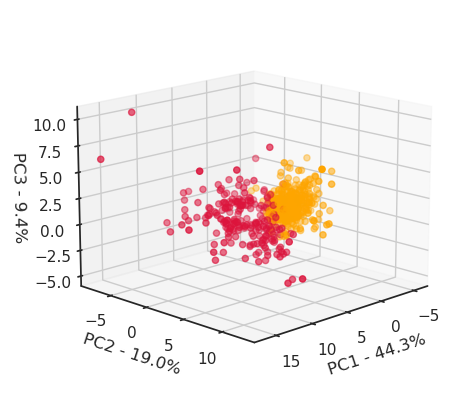

In [19]:
dict_colors = {'B': 'orange', 'M': 'crimson'} 
y_colors = [dict_colors[yi] for yi in y_pca]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed_df['PC1'], X_transformed_df['PC2'], X_transformed_df['PC3'], c=y_colors, cmap='coolwarm')
ax.set_xlabel('PC1 - ' + '{:.1f}%'.format(variance_ratios['PC1']))
ax.set_ylabel('PC2 - ' + '{:.1f}%'.format(variance_ratios['PC2']))
ax.set_zlabel('PC3 - ' + '{:.1f}%'.format(variance_ratios['PC3']))
ax.view_init(elev=15, azim=45)
plt.show()

# **Data Processing**

In [20]:
def pipeline(model):
    num_features_standard = num_var
    numeric_transformer  = Pipeline(steps=[
                         ('standard_scaler', RobustScaler())])
    preprocessor = ColumnTransformer(
      transformers=[
                 ('num', numeric_transformer, num_features_standard)])
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    return pipe

In [21]:
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    model_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}): {:.2f}%".format(model_name, model_acc * 100))
    
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [22]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
    scoring=make_scorer(balanced_accuracy_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [23]:
def plot_feature_importance(model, X_train, name):
    # Récupère l'importance des variables et le nom des variables
    importances = model.named_steps['classifier'].feature_importances_
    feature_names = X_train.columns
    
    # Crée un dataframe trié par ordre décroissant d'importance
    df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    df_importances = df_importances[df_importances['importance'] != 0]  # Filtre les variables ayant une importance nulle
    df_importances = df_importances.sort_values(by='importance', ascending=False)
    df_importances = df_importances.iloc[:10]  # Garde uniquement les 10 premières variables
    
    # Trace le diagramme en barres
    plt.figure(figsize=(6, 6))
    ax = sns.barplot(x='feature', y='importance', data=df_importances, palette="Blues_r")
    ax.set_title(name + " " + "Feature Importance")
    ax.set_xlabel("Features")
    ax.set_ylabel("Importance")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [24]:
def plot_first_trees(model, num_var):
    # Affiche les trois premiers arbres
    for i in range(3):
        plt.figure(figsize=(25, 10))
        tree.plot_tree(model.named_steps['classifier'][i], filled=True, feature_names=num_var)
        plt.show()

In [25]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(model, name):
    y_score = model.predict_proba(X)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, y_score)
    auprc = auc(recall, precision)

    fig = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUPRC={auprc:.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show(config=config)

In [26]:
def randomized_search_cv(model, param_grid, cross_val, X_train, y_train):
    clf = RandomizedSearchCV(model, param_grid, cv=cross_val, n_jobs=-1,
                             scoring=make_scorer(balanced_accuracy_score),
                             n_iter=5, verbose=1)
    clf.fit(X_train, y_train)
    return clf

# **Modélisation**

In [27]:
X = cancer.select_dtypes('number')
y = cancer['diagnosis'].replace({'B': 0, 'M': 1})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

In [30]:
kfold = KFold(n_splits=10) # Validation croisée

# **Logistic Regression**

In [31]:
param_grid_lr = {
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver': ['newton-cg','sag', 'saga'],
    'classifier__max_iter': [100, 500, 1000]
}

In [32]:
clf_lr = randomized_search_cv(pipeline(LogisticRegression(tol=1e-2,
                                                         class_weight='balanced',  penalty='l2',
                                                         multi_class='ovr', random_state=42)),
                              param_grid_lr, kfold ,X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [33]:
lr = clf_lr.best_estimator_
lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (LogisticRegression): 98.28%


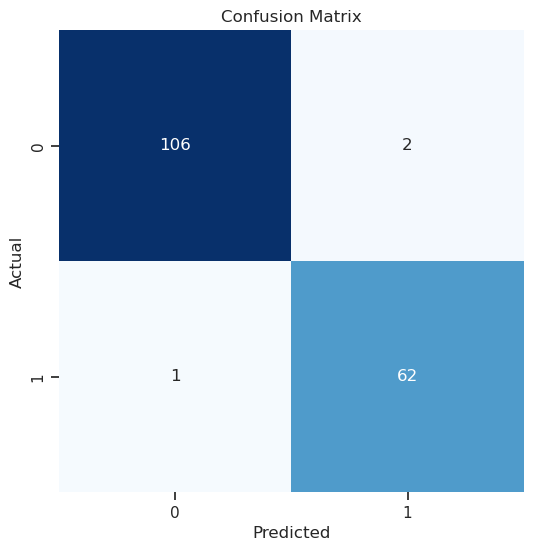

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [34]:
evaluate_model(lr,'LogisticRegression', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

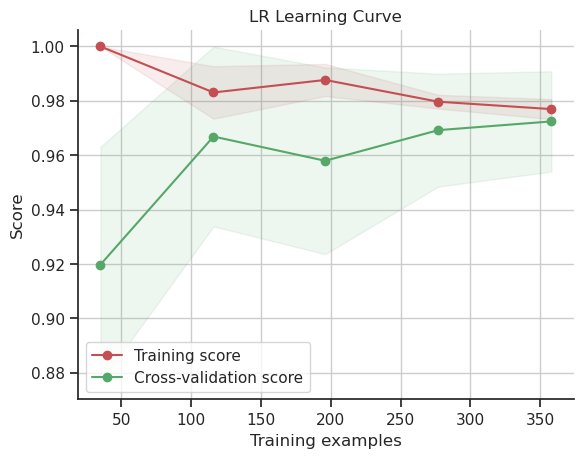

In [35]:
# Logistic Regression - Learning Curve 
plot_learning_curve(estimator=lr,title="LR Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

# **Decision Tree Classifier**

In [36]:
param_grid_dtc = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, 9, 11, 13],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5]
}

In [37]:
clf_dtc = randomized_search_cv(pipeline(DecisionTreeClassifier(class_weight='balanced')),
                              param_grid_dtc, kfold, X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [38]:
dtc = clf_dtc.best_estimator_
dtc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (DecisionTreeClassifier): 96.36%


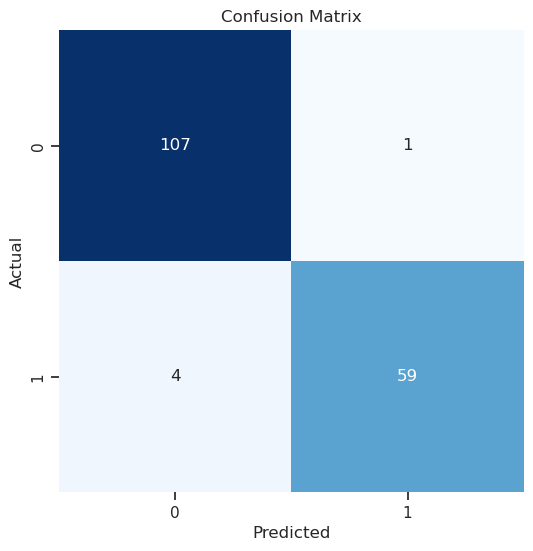

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       108
           1       0.98      0.94      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



In [39]:
evaluate_model(dtc,'DecisionTreeClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

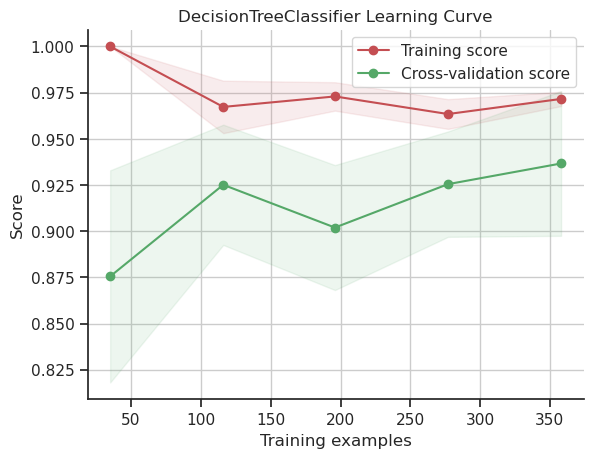

In [40]:
# DecisionTreeClassifier - Learning Curve 
plot_learning_curve(estimator=dtc,title="DecisionTreeClassifier Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

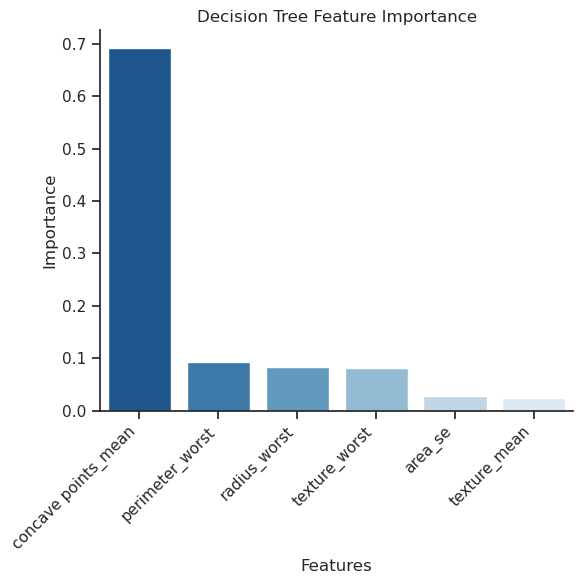

In [41]:
plot_feature_importance(dtc, X_train, 'Decision Tree')

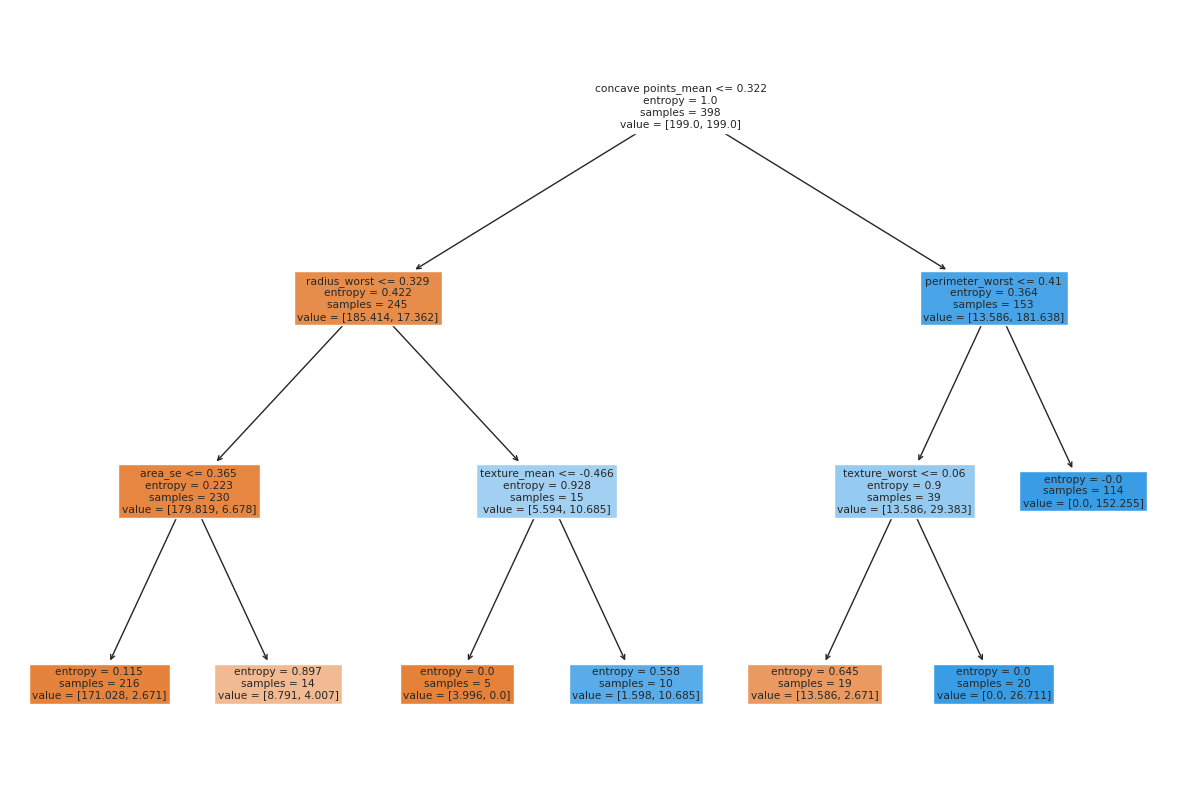

In [42]:
# Affiche l'arbre de décision
plt.figure(figsize=(15, 10))
tree.plot_tree(dtc.named_steps['classifier'], filled=True, feature_names=num_var)
plt.show()

# **Gradient Boosting Classifier**

In [43]:
param_grid_gbc = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}

In [44]:
clf_gbc = randomized_search_cv(pipeline(GradientBoostingClassifier()),
                              param_grid_gbc, kfold, X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [45]:
gbc = clf_gbc.best_estimator_
gbc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (GradientBoostingClassifier): 95.90%


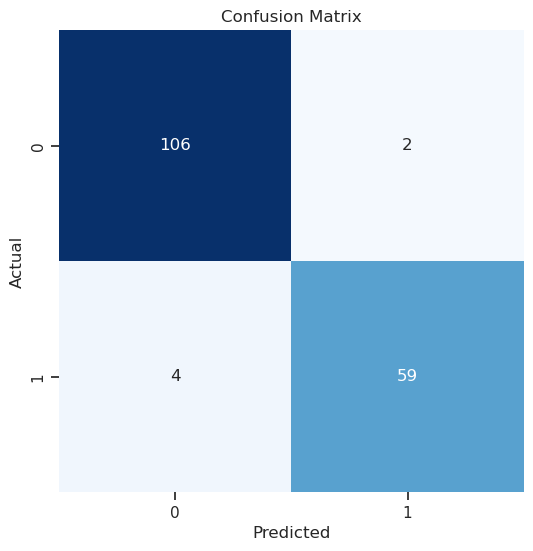

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [46]:
evaluate_model(gbc,'GradientBoostingClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

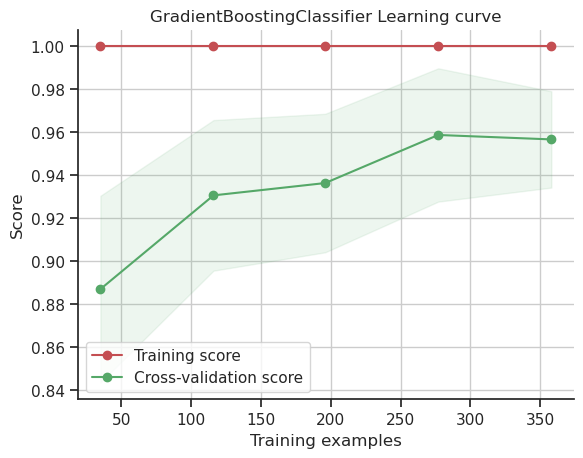

In [47]:
# Gradient Boosting Classifier - Learning Curve 
plot_learning_curve(estimator=gbc, title="GradientBoostingClassifier Learning curve",
                    X=X_train, y=y_train, cv=kfold)

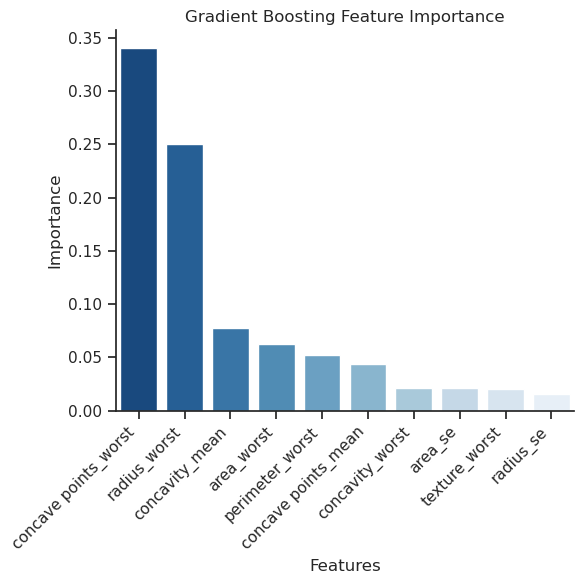

In [48]:
plot_feature_importance(gbc, X_train, 'Gradient Boosting')

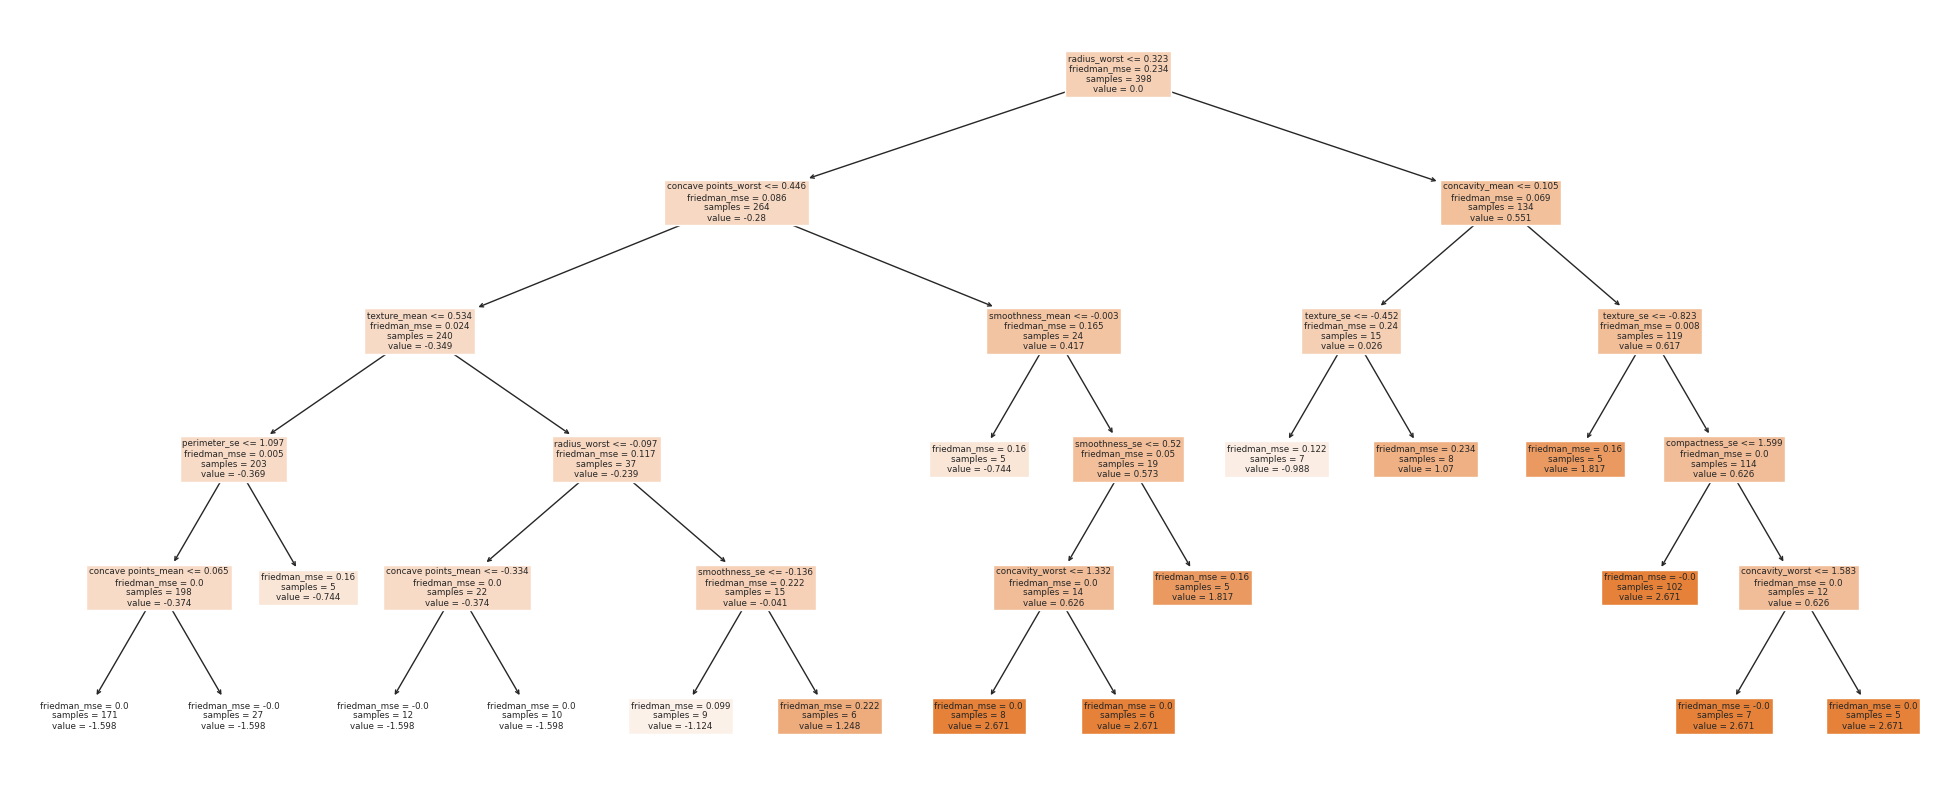

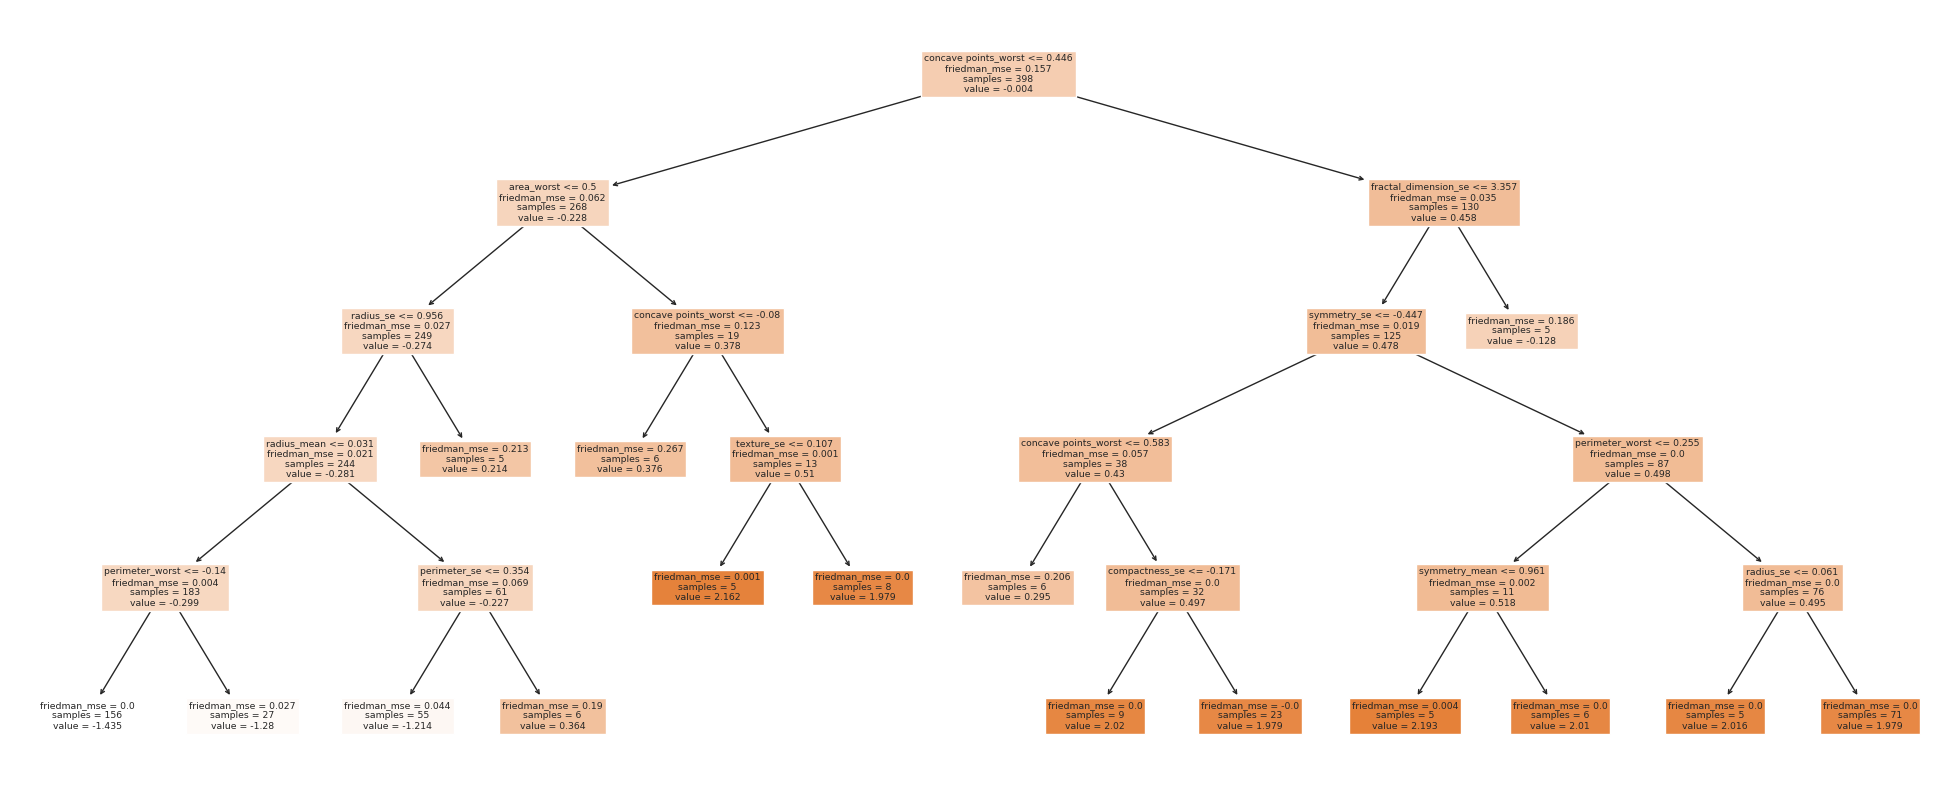

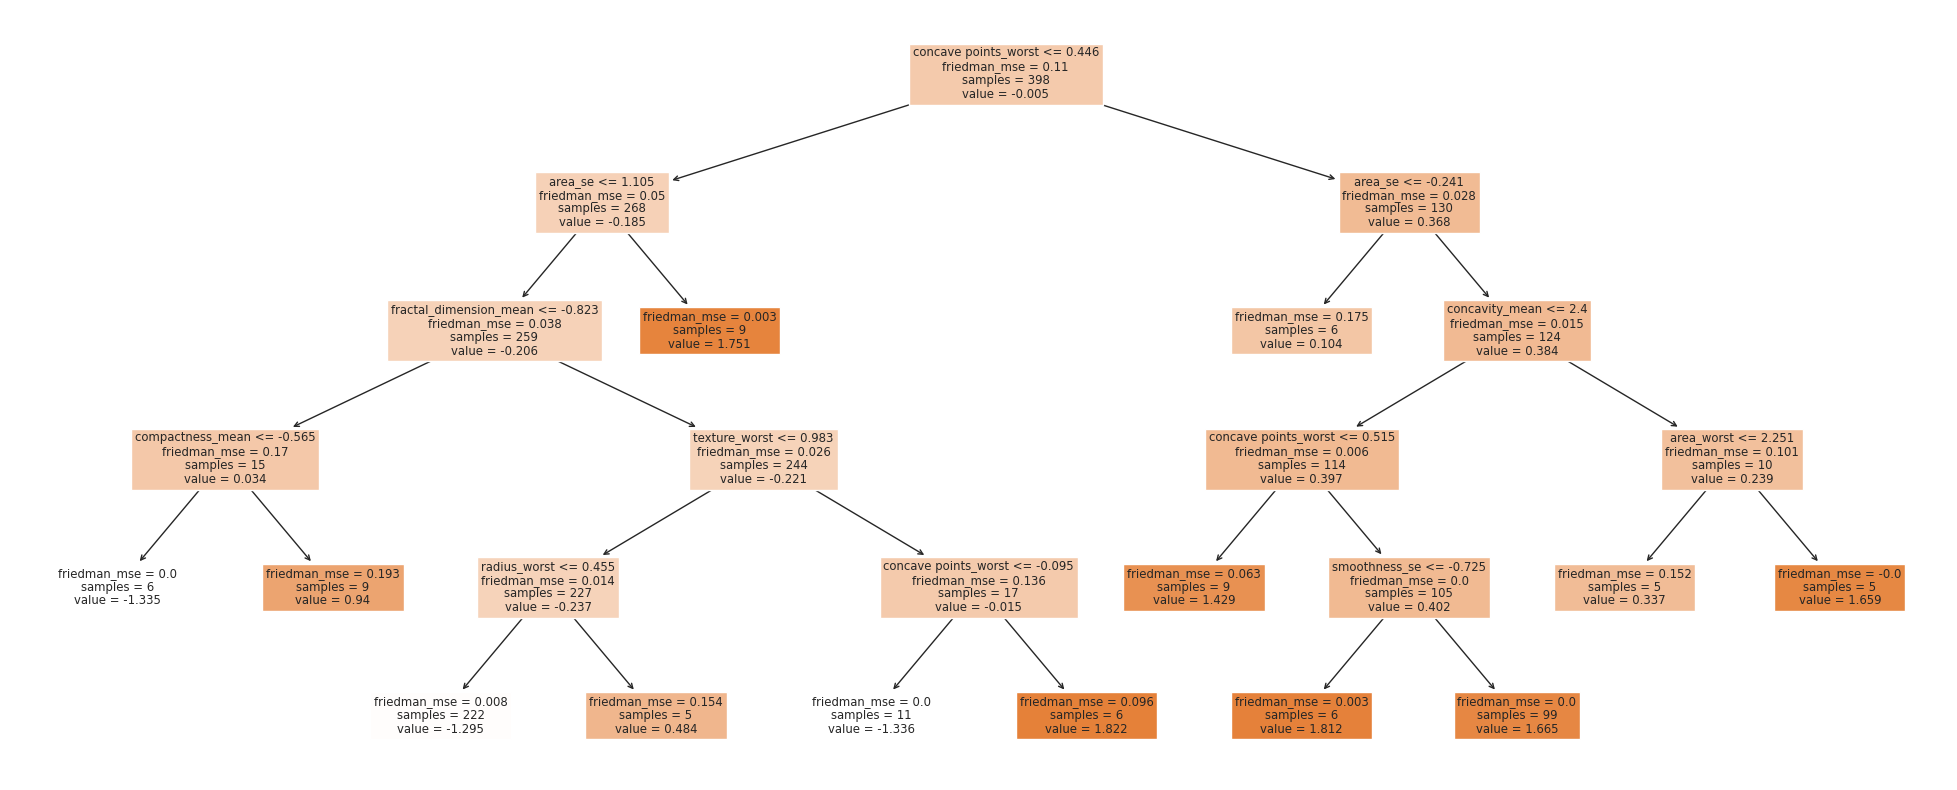

In [49]:
# Affiche les trois premiers arbres
for i in range(3):
    plt.figure(figsize=(25, 10))
    tree.plot_tree(gbc.named_steps['classifier'][i][0], filled=True, feature_names=num_var)
    plt.show()

# **Support Vector Classification**

In [50]:
param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100], 
    'classifier__kernel': ['linear', 'rbf'], 
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

In [51]:
clf_svc = randomized_search_cv(pipeline(SVC(class_weight='balanced')),
                              param_grid_svc, kfold, X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [52]:
svc = clf_svc.best_estimator_
svc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (SVC): 95.63%


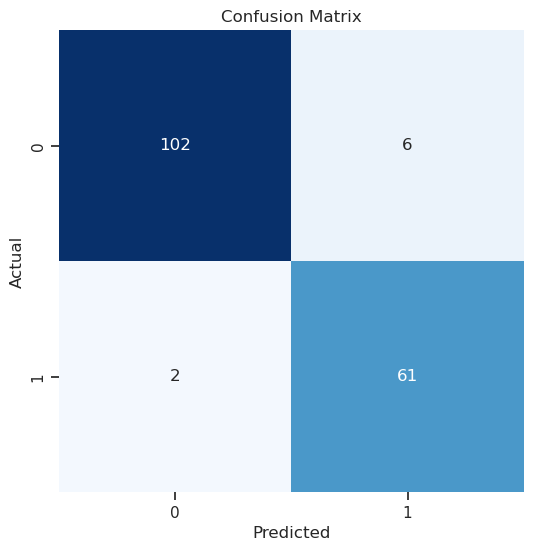

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       108
           1       0.91      0.97      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.95      0.95      0.95       171



In [53]:
evaluate_model(svc,'SVC', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

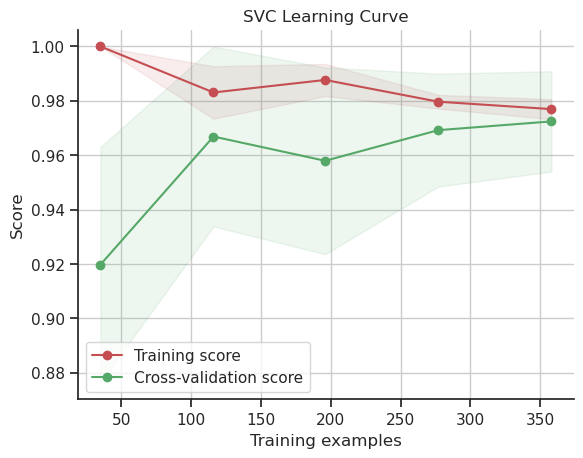

In [54]:
# SVC - Learning Curve 
plot_learning_curve(estimator=lr,title="SVC Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

# **K-Nearest Neighbors**


In [55]:
param_grid_neigh = {
    'classifier__n_neighbors': np.arange(1, 25),
    'classifier__metric': ['euclidean', 'manhattan'],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],
}

In [56]:
clf_neigh = randomized_search_cv(pipeline(KNeighborsClassifier()), param_grid_neigh, kfold ,X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [57]:
neigh = clf_neigh.best_estimator_
neigh

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (KNeighborsClassifier): 95.90%


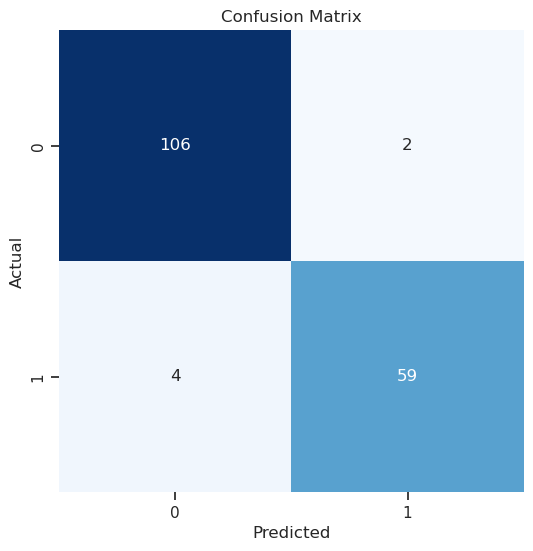

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [58]:
evaluate_model(neigh,'KNeighborsClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

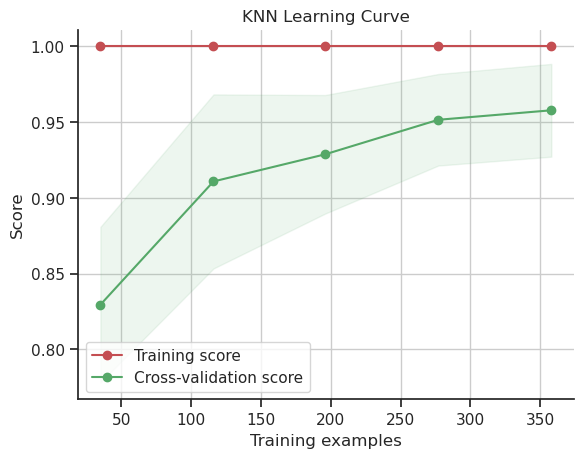

In [59]:
# K-Nearest Neighbors - Learning Curve 
plot_learning_curve(estimator=neigh,title="KNN Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

In [60]:
f1_score(y_test, neigh.predict(X_test), average='weighted')

0.9647902680643603

In [61]:
balanced_accuracy_score(y_test, neigh.predict(X_test))

0.9589947089947091

# **Random Forest**

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 4, 6, 8, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 12, 15, 18, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [63]:
# Create the random grid
random_grid = {
               'classifier__n_estimators': n_estimators,
               'classifier__max_features':max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap
}

In [64]:
clf_rf = randomized_search_cv(pipeline(RandomForestClassifier(class_weight='balanced',
                                                             random_state=42)), random_grid, kfold ,X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [65]:
rf = clf_rf.best_estimator_
rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (RandomForestClassifier): 96.69%


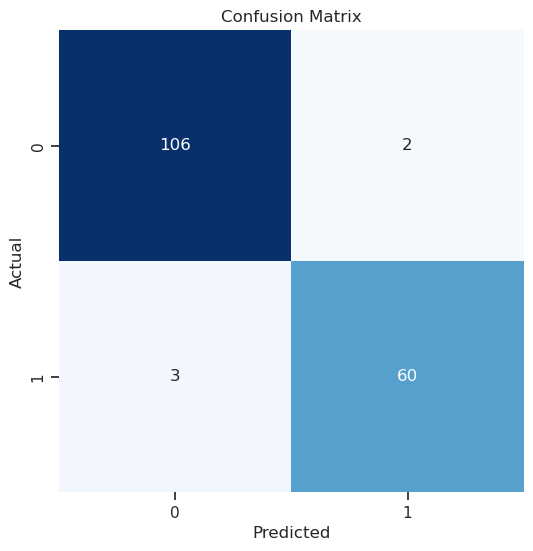

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       108
           1       0.97      0.95      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [66]:
evaluate_model(rf,'RandomForestClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

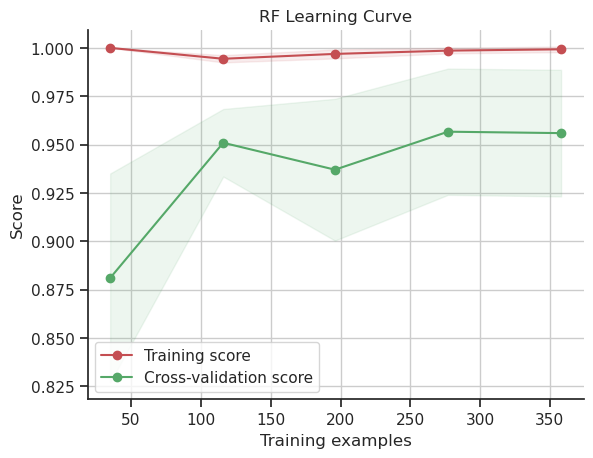

In [67]:
# Random Forest - Learning Curve 
plot_learning_curve(estimator=rf,title="RF Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

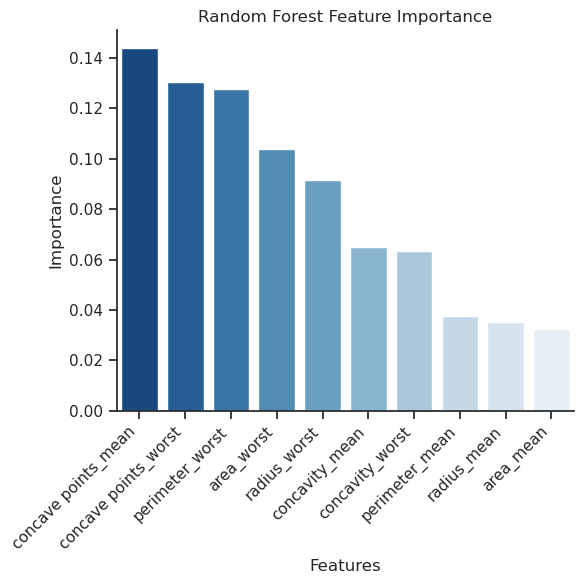

In [68]:
plot_feature_importance(rf, X_train, 'Random Forest')

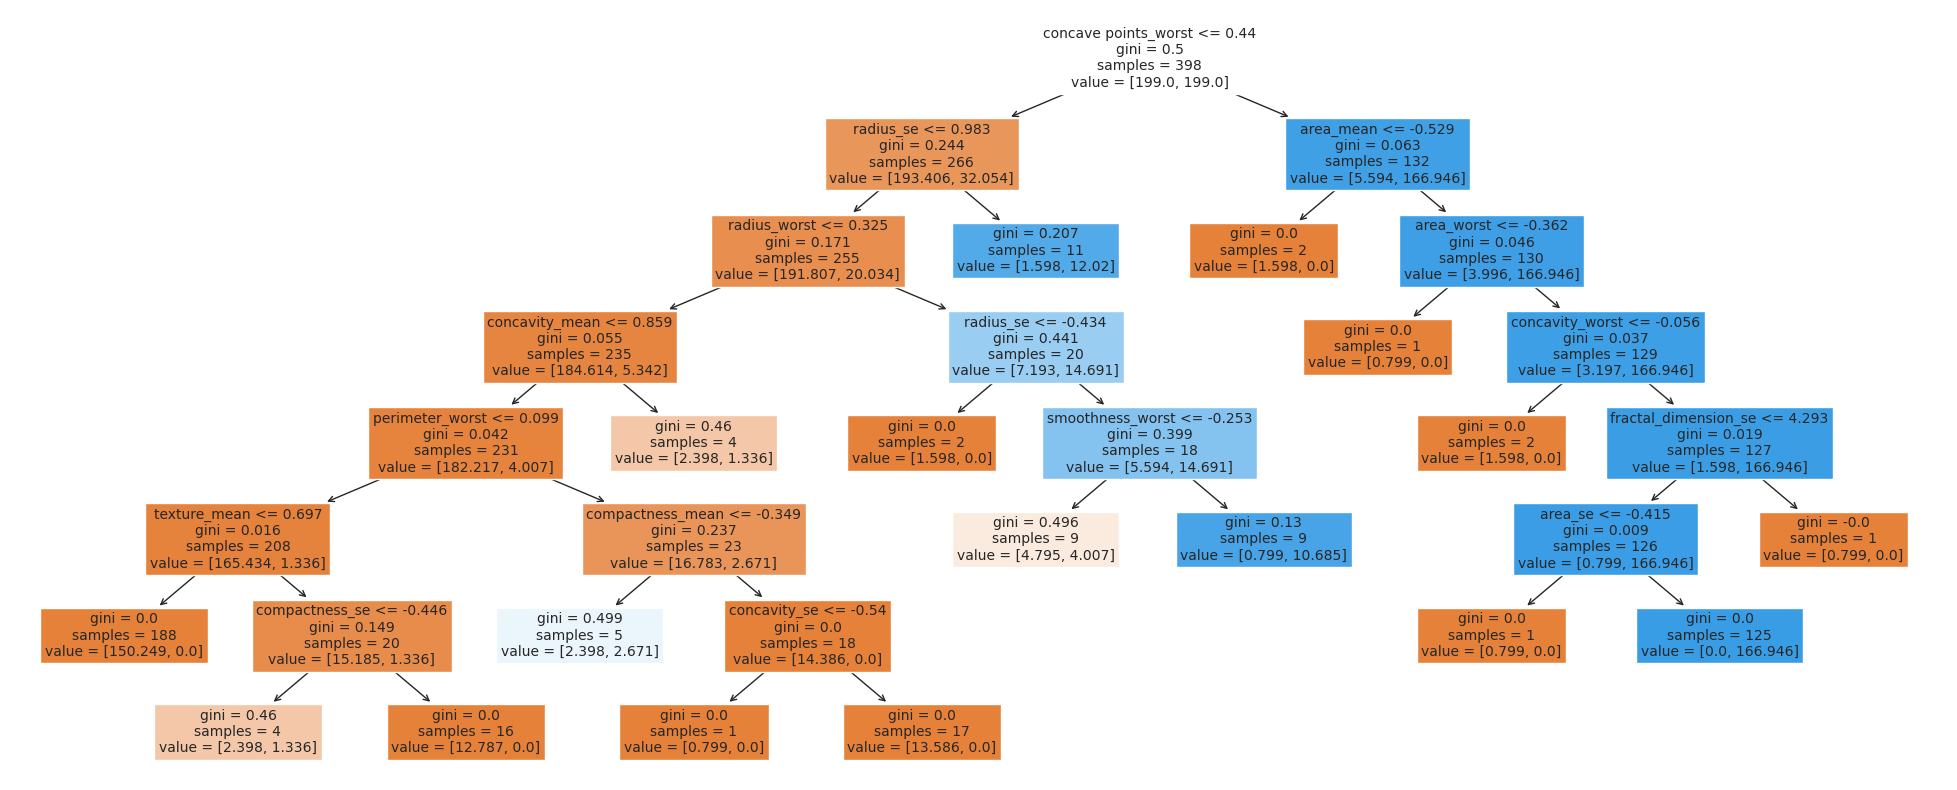

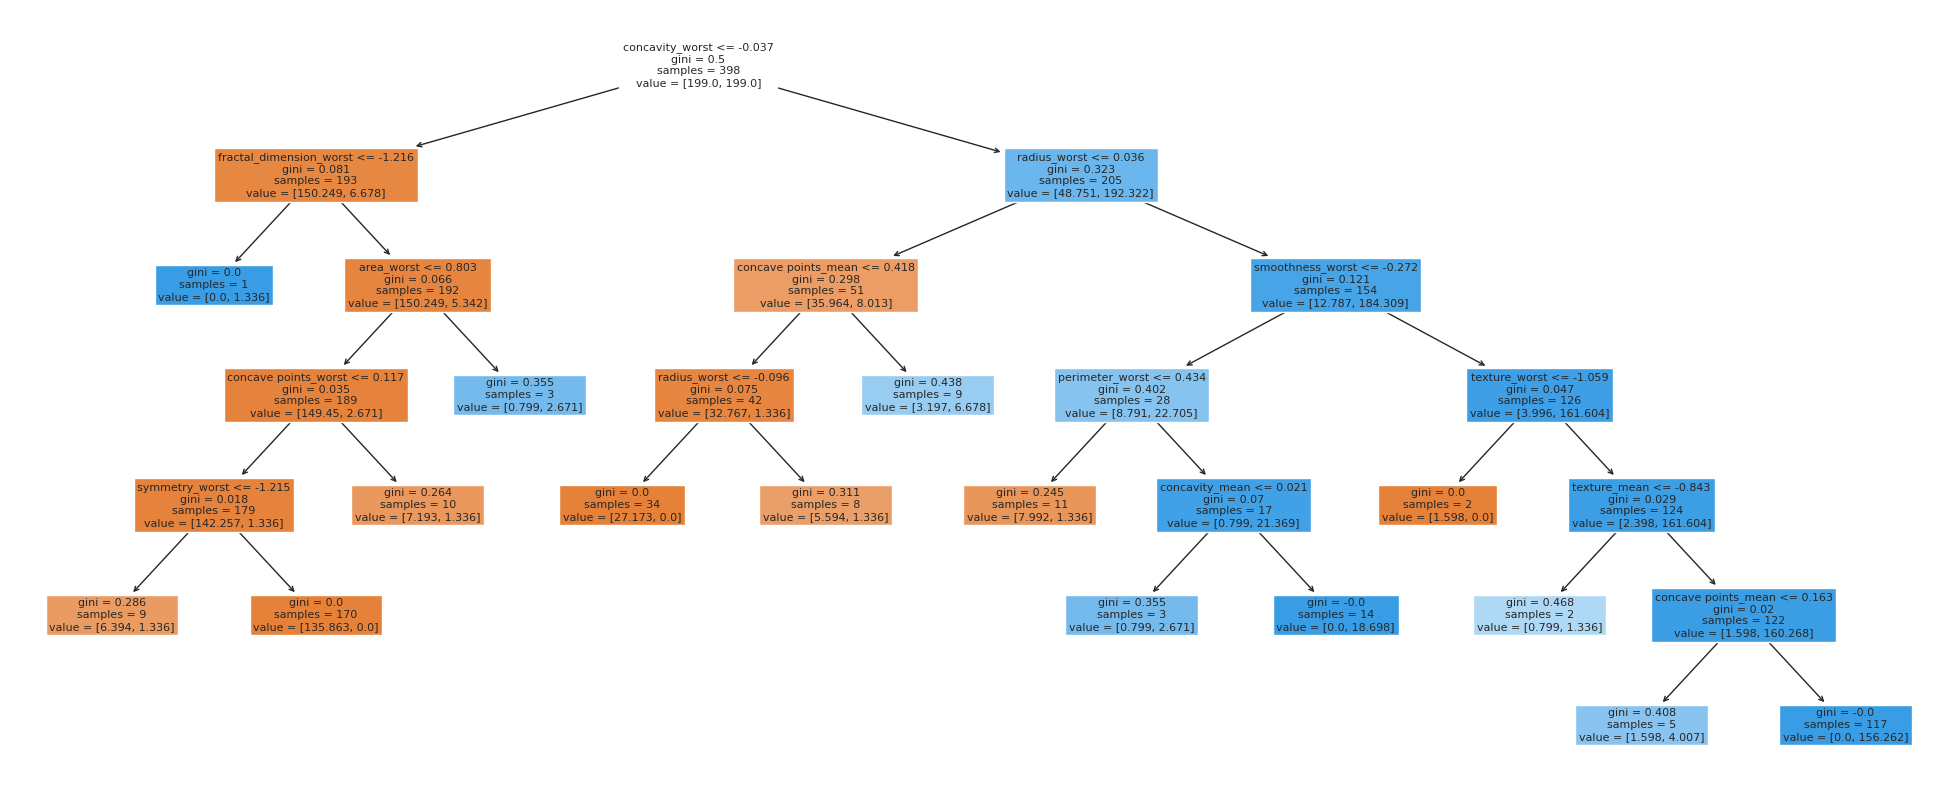

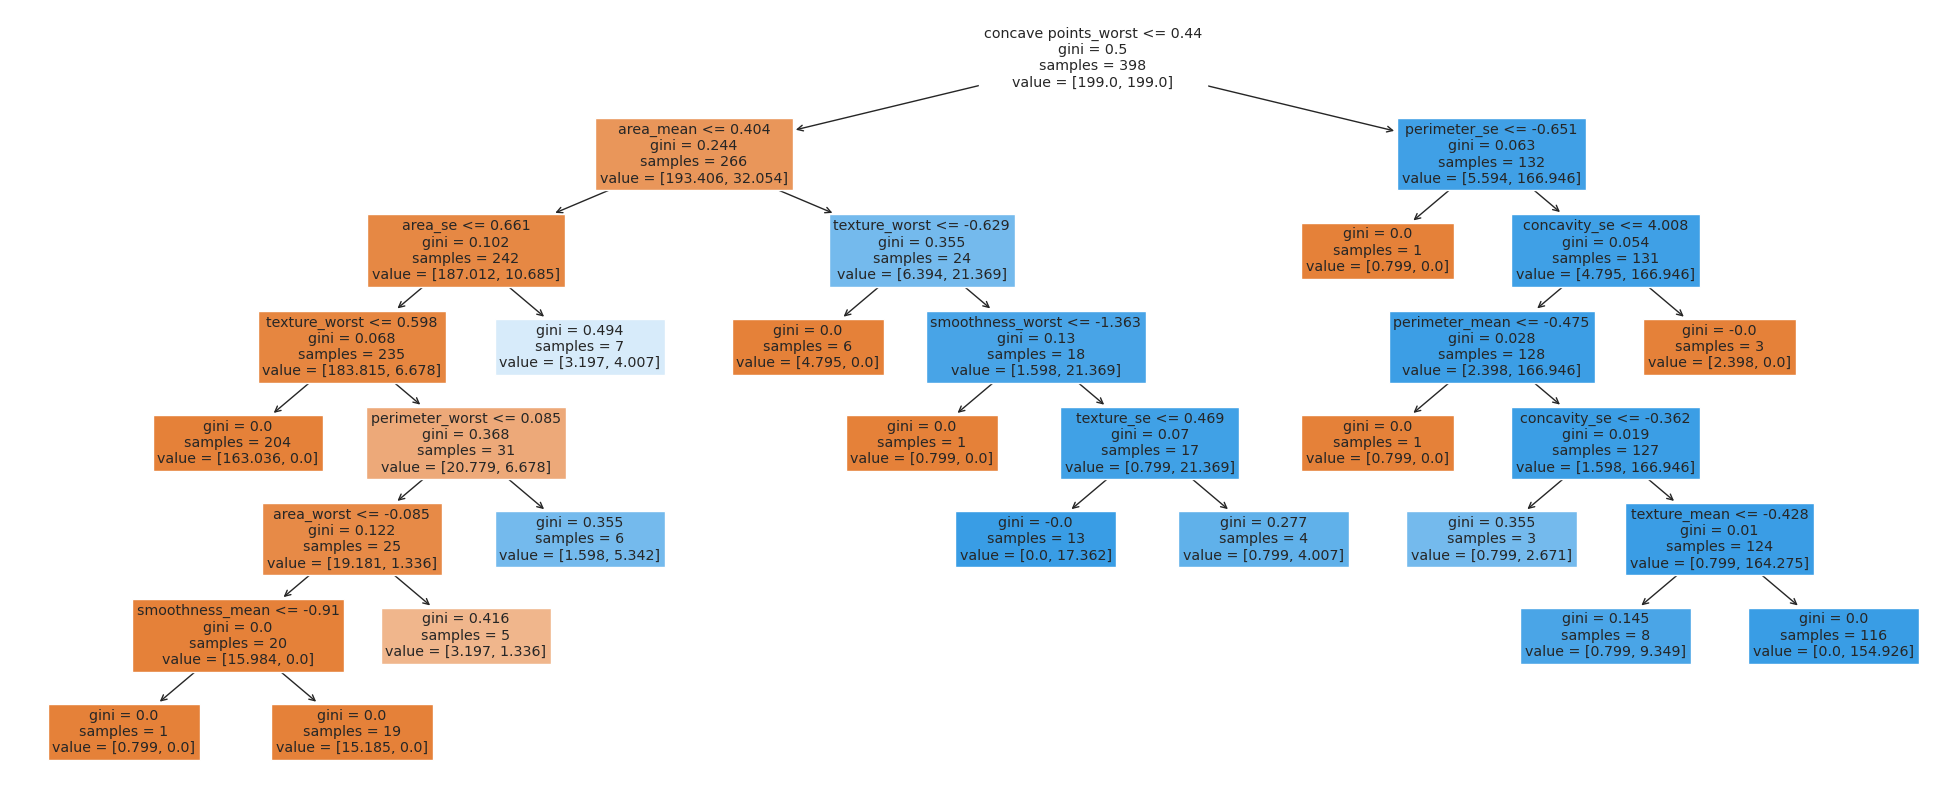

In [69]:
plot_first_trees(rf, num_var)

# **XGBoost Classifier**

In [70]:
param_grid_xgb = {
    'classifier__max_depth':np.arange(2, 10),
    'classifier__n_estimators':np.arange(100, 500, 100),
    'classifier__learning_rate':np.arange(0.01, 0.1, 0.01)
}

In [71]:
clf_xgb = randomized_search_cv(pipeline(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                                                         random_state=42)),
                              param_grid_xgb, kfold, X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [72]:
best_xgb = clf_xgb.best_estimator_
best_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (XGBoostClassifier): 97.35%


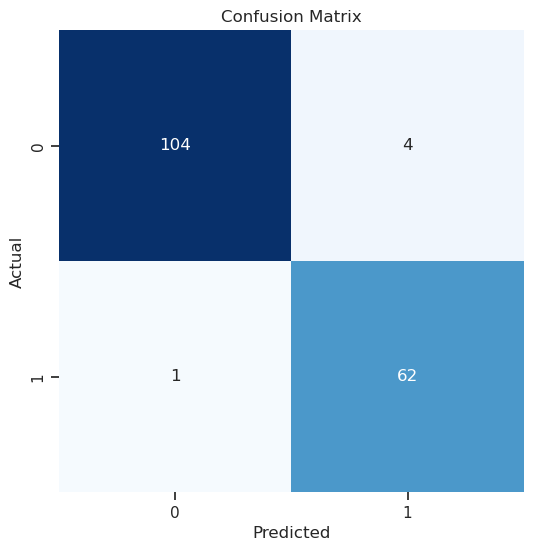

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       108
           1       0.94      0.98      0.96        63

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [73]:
evaluate_model(best_xgb,'XGBoostClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

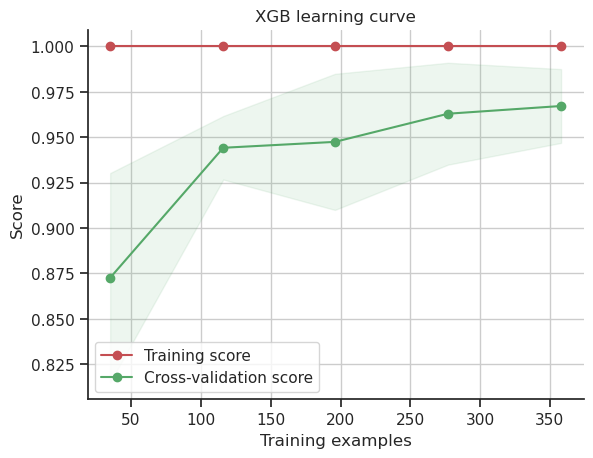

In [74]:
# XGBoost - Learning Curve 
plot_learning_curve(estimator=best_xgb, title="XGB learning curve",
                    X=X_train, y=y_train, cv=kfold)

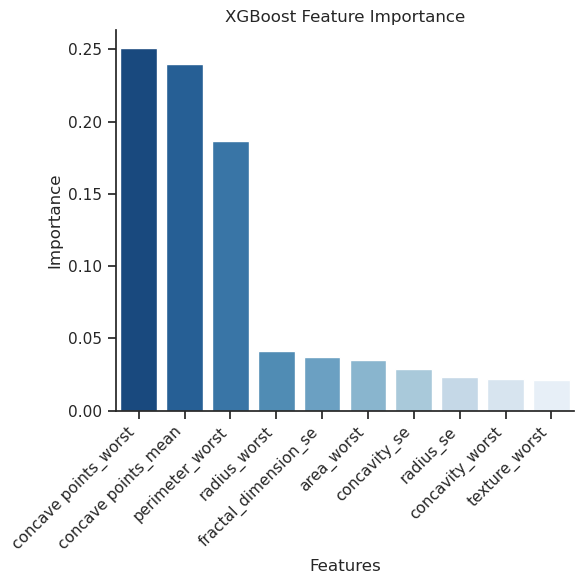

In [75]:
plot_feature_importance(best_xgb, X_train, 'XGBoost')

# **Gaussian Naive Bayes**

In [76]:
param_grid_gnb = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
    'classifier__priors': [None, [0.25, 0.75], [0.5, 0.5]]
}

In [77]:
clf_gnb = randomized_search_cv(pipeline(GaussianNB()),
                              param_grid_gnb, kfold, X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [78]:
gnb = clf_gnb.best_estimator_
gnb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

Balanced accuracy (GaussianNB): 92.92%


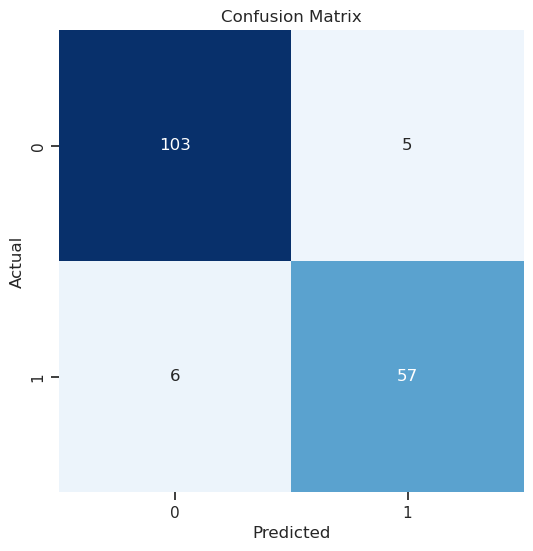

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       108
           1       0.92      0.90      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [79]:
evaluate_model(gnb,'GaussianNB', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

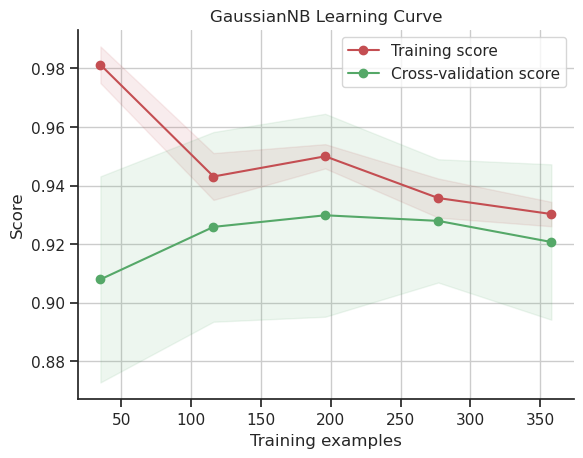

In [80]:
# GaussianNB - Learning Curve 
plot_learning_curve(estimator=gnb,title="GaussianNB Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

# **Artificial Neural Network**

In [81]:
# Crée une instance de la classe RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Applique l'oversampling aux données d'entraînement
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

In [82]:
X_train_balanced.shape, X_test.shape, y_train_balanced.shape, y_test.shape

((498, 30), (171, 30), (498,), (171,))

In [83]:
# Création du pipeline de prétraitement des données
preprocessor = Pipeline(steps=[('scaler', StandardScaler())])

In [84]:
# Prétraitement des données
X_train_processed = preprocessor.fit_transform(X_train_balanced)
X_test_processed = preprocessor.transform(X_test)

In [85]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 

    plt.figure(figsize=(12, 8))
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    
    # Loss
    for l in loss_list:
        axs[0].plot(history.history[l], label='Train loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(history.history[l], label='Validation loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Accuracy
    for l in acc_list:
        axs[1].plot(history.history[l], label='Train accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    for l in val_acc_list:
        axs[1].plot(history.history[l], label='Validation accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    
    plt.show()

In [86]:
# Création du modèle de réseau de neurones
model_ann = Sequential()
model_ann.add(Dense(units=128, activation='relu'))
model_ann.add(Dense(units=32, activation='relu'))
model_ann.add(Dense(units=16, activation='relu'))
model_ann.add(Dense(units=1, activation='sigmoid', input_dim=X.shape[1]))
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/1000
11/11 [==============================] - 1s 26ms/step - loss: 0.4385 - accuracy: 0.8420 - val_loss: 0.4349 - val_accuracy: 0.8200
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.2536 - accuracy: 0.9224 - val_loss: 0.3205 - val_accuracy: 0.8800
Epoch 3/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.9483 - val_loss: 0.2339 - val_accuracy: 0.9200
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.1190 - accuracy: 0.9713 - val_loss: 0.1791 - val_accuracy: 0.9267
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0899 - accuracy: 0.9828 - val_loss: 0.1586 - val_accuracy: 0.9333
Epoch 6/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0740 - accuracy: 0.9828 - val_loss: 0.1445 - val_accuracy: 0.9400
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0614 - accuracy: 0.9856 - val_loss: 0.1419 - val_accuracy: 0.9400
Epoch

<Figure size 1200x800 with 0 Axes>

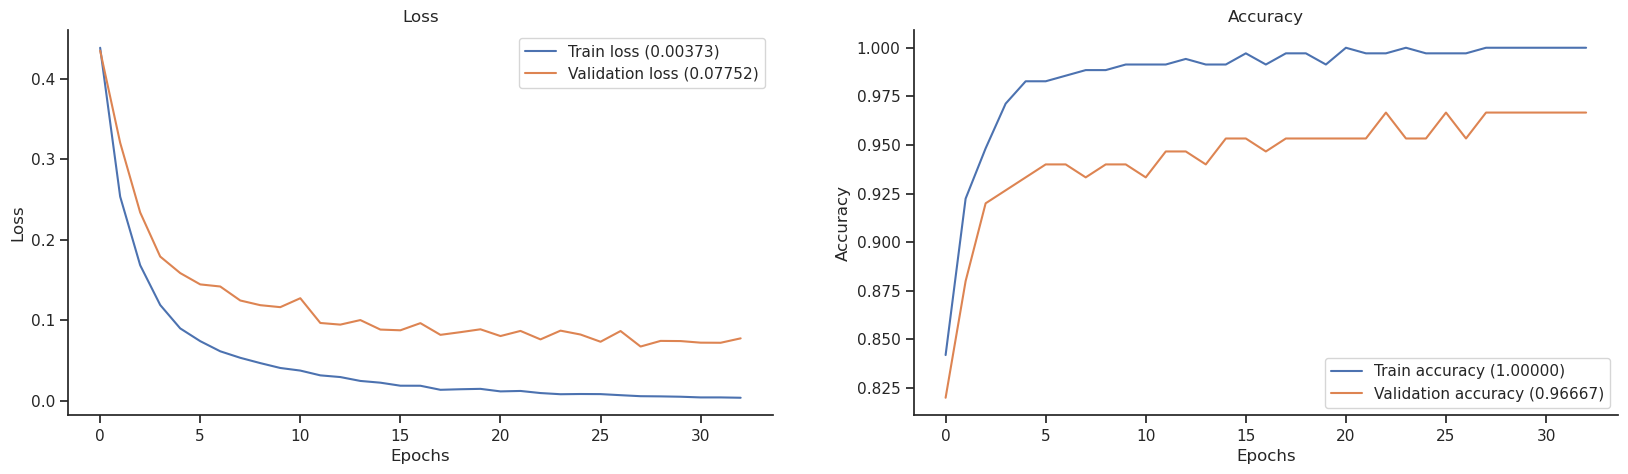

In [87]:
es = EarlyStopping(monitor='val_loss', patience=5)
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_ann.fit(X_train_processed, y_train_balanced, epochs=1000, validation_split=0.3, callbacks=[es])
plot_history(history)

In [88]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Prédictions sur les données de test
y_pred = model_ann.predict(X_test_processed)

# Convertis les prédictions en classe binaire (0 ou 1)
y_pred = np.where(y_pred > 0.5, 1, 0)

6/6 [==============================] - 0s 2ms/step


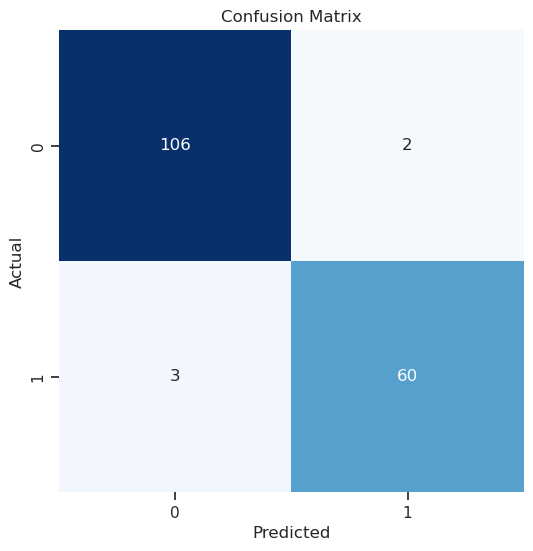

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       108
           1       0.97      0.95      0.96        63

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [90]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
    
print("Classification Report:\n----------------------\n", clr)

In [91]:
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score : ", f1)

F1-score :  0.9707106475867088


In [92]:
bas = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy Score : ", bas)

Balanced Accuracy Score :  0.966931216931217


# **Voting Classifier**

In [93]:
param_grid_vc = {
    'voting': ['hard', 'soft'],
    'weights': [[1,1], [2,1], [2,2]]
}

In [94]:
clf_vc = randomized_search_cv(VotingClassifier(estimators=[('model1', lr), ('model2', rf)]),
                              param_grid_vc, kfold ,X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [95]:
clf_vc

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=VotingClassifier(estimators=[('model1',
                                                           Pipeline(steps=[('preprocessor',
                                                                            ColumnTransformer(transformers=[('num',
                                                                                                             Pipeline(steps=[('standard_scaler',
                                                                                                                              RobustScaler())]),
                                                                                                             ['radius_mean',
                                                                                                              'texture_mean',
                                                                                                          

Balanced accuracy (VotingClassifier): 98.74%


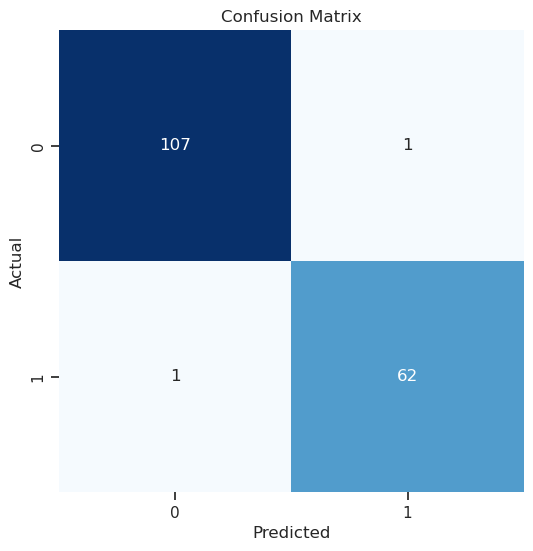

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       108
           1       0.98      0.98      0.98        63

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [96]:
evaluate_model(clf_vc,'VotingClassifier', X_test, y_test)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

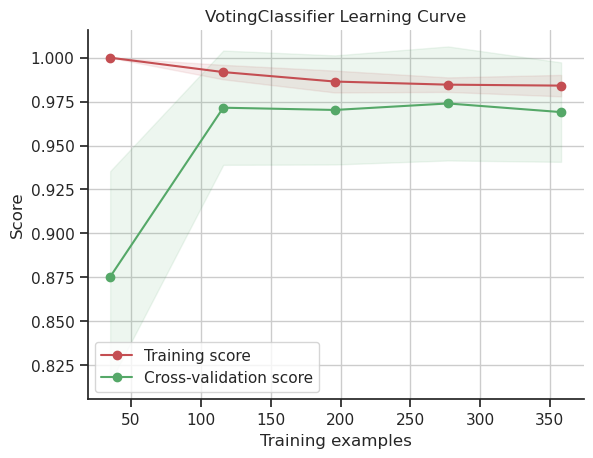

In [97]:
# Voting Classifier - Learning Curve 
plot_learning_curve(estimator=clf_vc, title="VotingClassifier Learning Curve",
                    X=X_train, y=y_train, cv=kfold)

# **Comparison of Models**

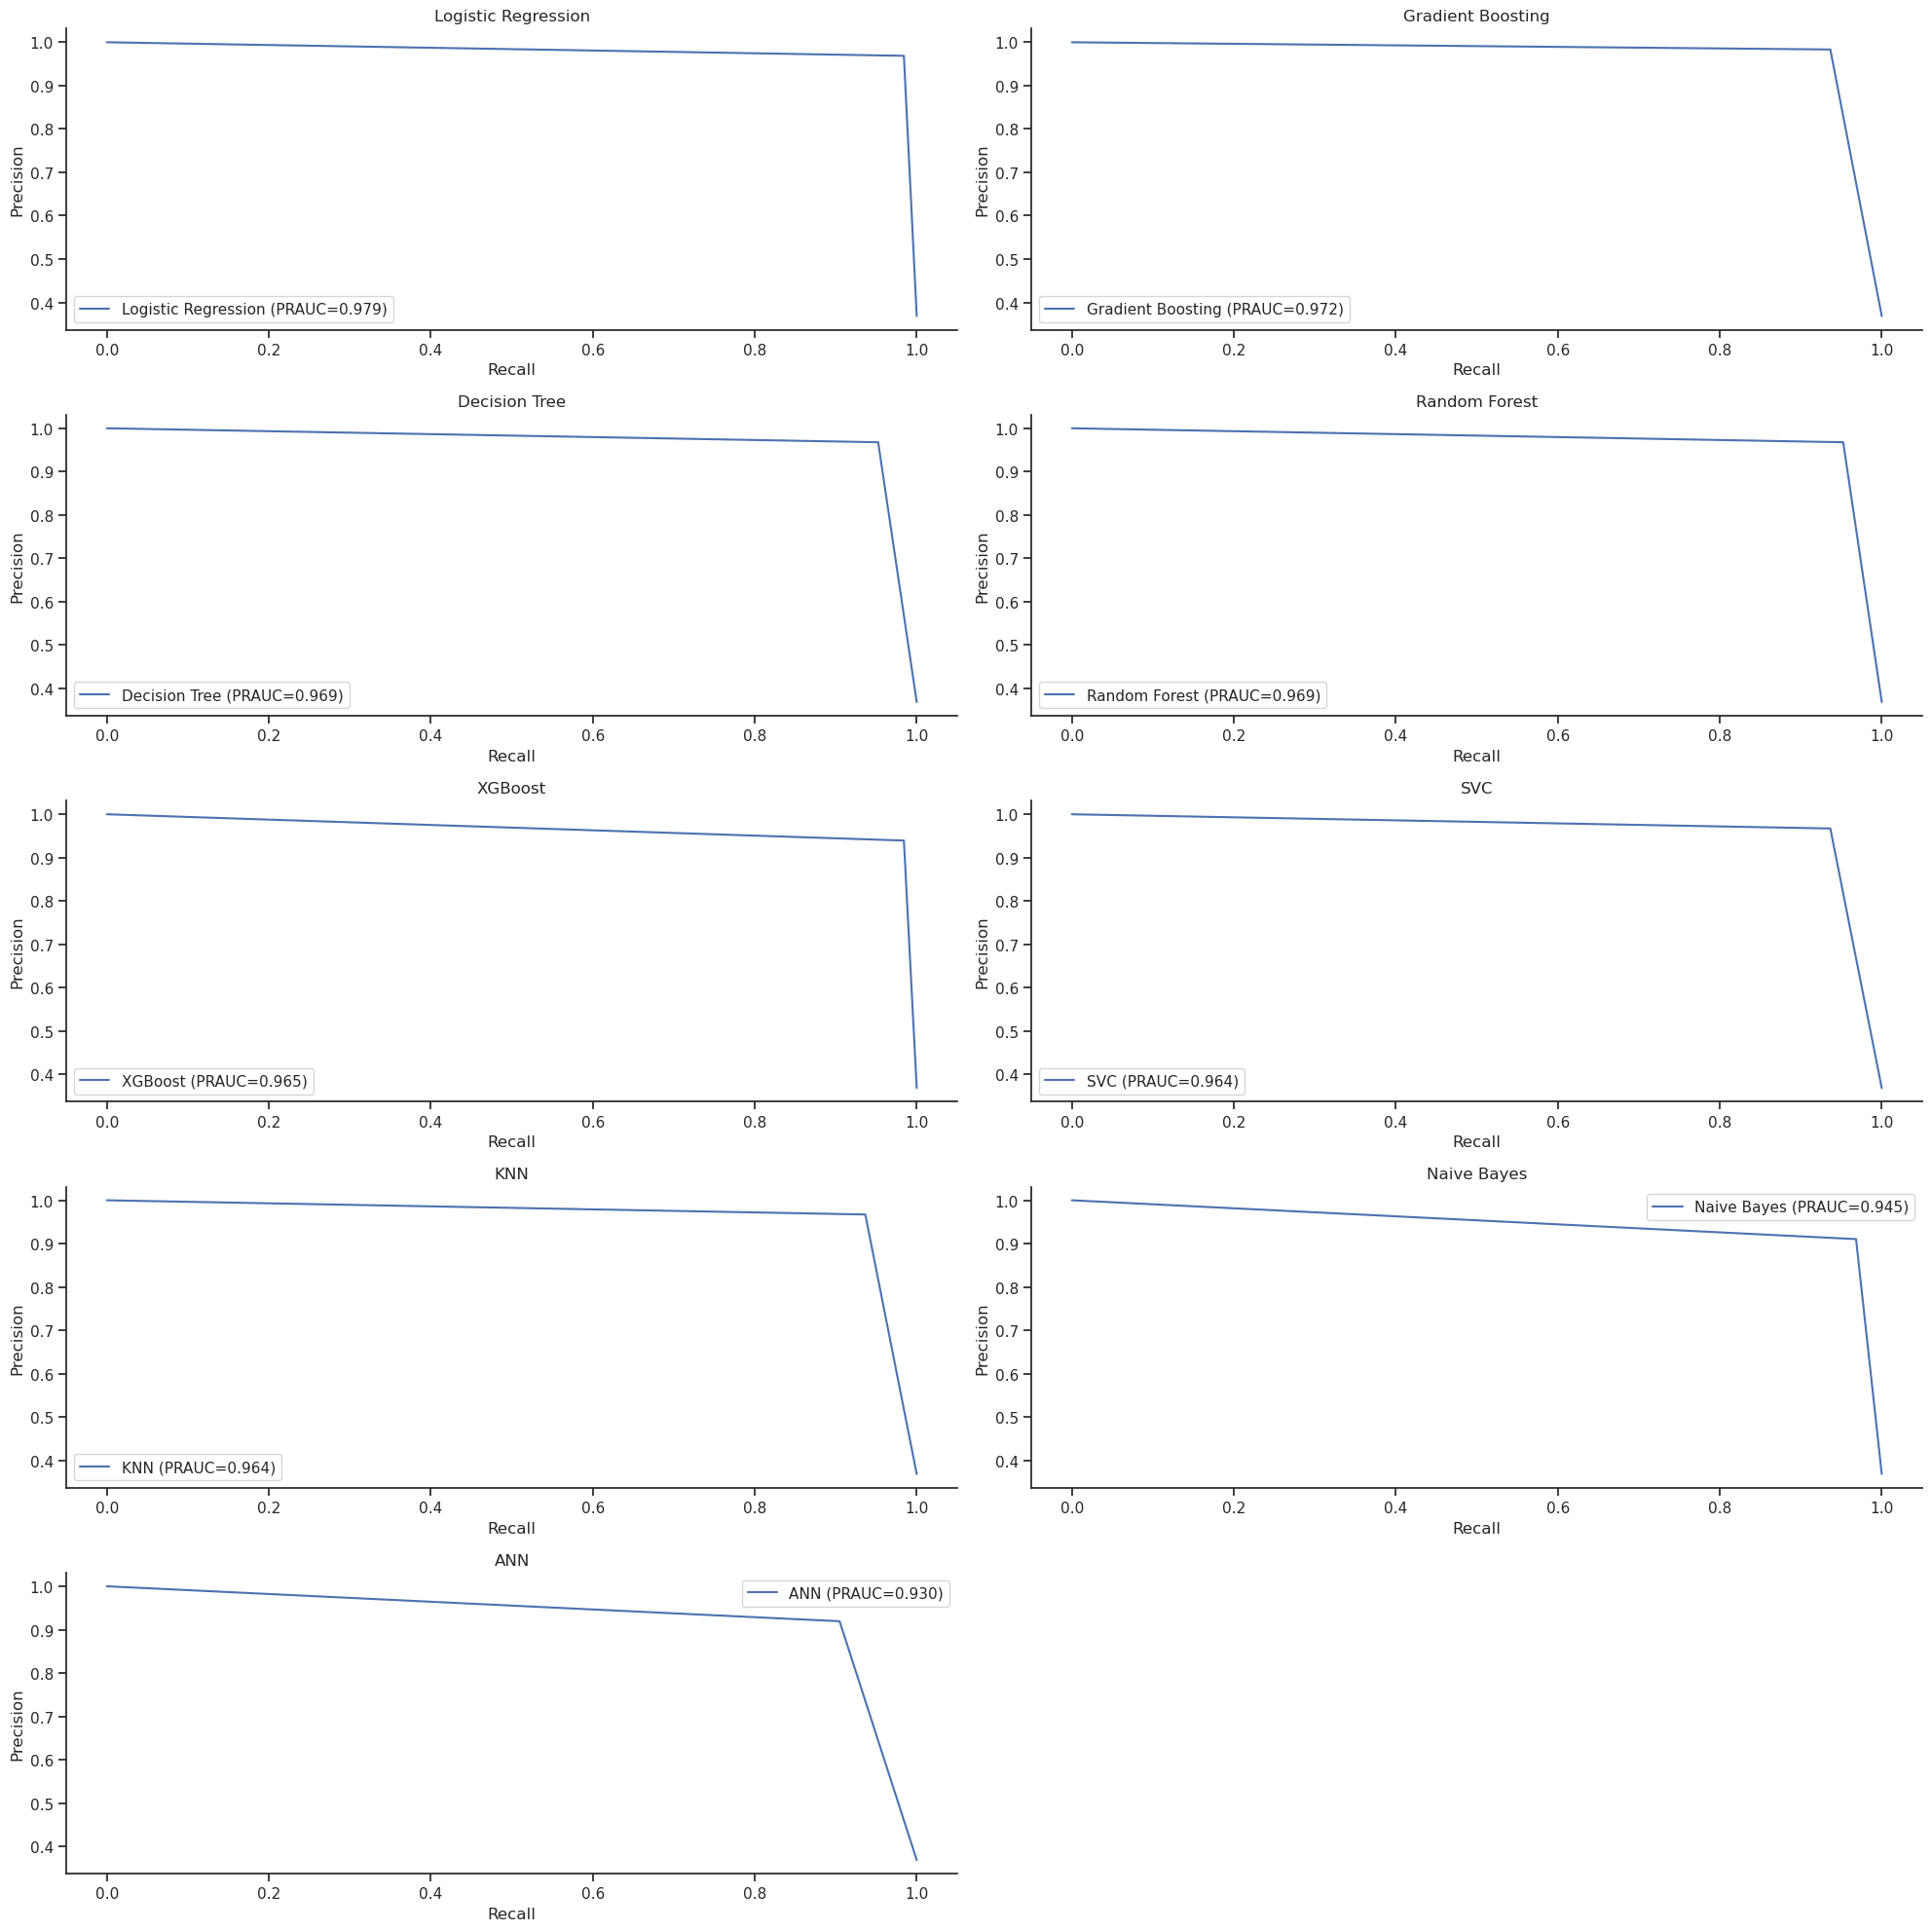

In [98]:
# Modèles entraînés et leurs prédictions sur les données de test dans les listes suivantes :
models = [lr, neigh, rf, best_xgb, dtc, gbc, svc, gnb, model_ann]
model_names = ['Logistic Regression', 'KNN', 'Random Forest', 'XGBoost', 'Decision Tree', 'Gradient Boosting', 'SVC', 'Naive Bayes', 'ANN']
predictions = [lr.predict(X_test), neigh.predict(X_test),
               rf.predict(X_test), best_xgb.predict(X_test),
               y_pred, dtc.predict(X_test), gbc.predict(X_test),
              svc.predict(X_test), gnb.predict(X_test)]

# Calcul les courbes de précision-rappel pour chaque modèle et stock les précisions (precision) et les rappels (recall) dans des listes
precisions, recalls, praucs = [], [], []
for i, clf_model in enumerate(models):
    precision, recall, _ = precision_recall_curve(y_test, predictions[i])
    prauc = auc(recall, precision)
    precisions.append(precision)
    recalls.append(recall)
    praucs.append(prauc)

# Tri les modèles par ordre décroissant du PRAUC
indices = np.argsort(praucs)[::-1]
models_sorted = [models[i] for i in indices]
model_names_sorted = [model_names[i] for i in indices]
praucs_sorted = [praucs[i] for i in indices]

# Crée la figure Seaborn
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
axs = axs.flatten()

# Ajoute les courbes PRAUC pour chaque modèle à la figure
for i in range(len(models)):
    axs[i].plot(recalls[indices[i]], precisions[indices[i]], label=f'{model_names_sorted[i]} (PRAUC={praucs_sorted[i]:.3f})')
    axs[i].set_title(model_names_sorted[i])
    axs[i].set_xlabel('Recall')
    axs[i].set_ylabel('Precision')
    axs[i].legend()

# Supprime les axes inutiles
for ax in axs[len(models):]:
    ax.remove()

plt.tight_layout()
plt.show()